<a href="https://colab.research.google.com/github/ereny123/Multitasking-MThesis-2024/blob/main/Pytorch_NET_Singletask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import time

In [ ]:
#create a model class
class Model(nn.Module):
  #Input (Tasks) random array of 9 units
  def __init__(self, in_tasks=9, in_stim=9, hidden=100, output=9, bias_weight=-2, coeff=0.3, thresh=0.0001):
    super().__init__()

    #Set Parameters
    self.bias_weight = bias_weight   # default bias weight
    self.coeff = coeff
    self.thresh = thresh

    self.task_hidden=nn.Linear(in_tasks, hidden)    #input layer(tasks) --> hidden layer
    self.stim_hidden=nn.Linear(in_stim, hidden)     #input layer(stimuls) --> hidden layer
    self.task_out=nn.Linear(in_tasks, output)       #Input Layer(tasks) --> output layer
    self.hidden_out=nn.Linear(hidden, output)       #hidden layer --> output layer

    self.task_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_tasks).uniform_(-0.1, 0.1))   #input(tasks)-->hidden  weight
    self.task_out.weight=nn.Parameter(torch.FloatTensor(output, in_tasks).uniform_(-0.1, 0.1))      #input(tasks) --> output weight
    self.stim_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_stim).uniform_(-0.1, 0.1))    #input(stimulus) -->hidden weight
    self.hidden_out.weight=nn.Parameter(torch.FloatTensor(output, hidden).uniform_(-0.1, 0.1))      #hidden-->output  weight


    # print("Task Hidden Weight Shape:", self.task_hidden.weight.shape)
    # print("Task Output Weight Shape:", self.task_out.weight.shape)
    # print("Stimulus Hidden Weight Shape:", self.stim_hidden.weight.shape)
    # print("Hidden Output Weight Shape:", self.hidden_out.weight.shape)

    self.task_hidden.bias=nn.Parameter(torch.ones(hidden) * bias_weight)                   #hidden layer bias
    self.hidden_out.bias=nn.Parameter(torch.ones(output) * bias_weight)                    #output layer bias

  def forward(self, taskData, stimulusData):

    h_act=torch.sigmoid(self.task_hidden(taskData)+self.stim_hidden(stimulusData))   #hidden layer activation
    out_act= torch.sigmoid(self.hidden_out(h_act)+self.task_out(taskData))           #output layer activation

    return h_act, out_act
    print("h_act shape:", h_act.shape)
    print("out_act shape:", out_act.shape)

#Train Online Method using back propagation
def trainOnline(model, taskData, stimulusData, targetData, iterations, thresh=0.0001, lr=0.1):

    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    MSE_log = []

    with tqdm(total=iterations) as pbar:

        for i in range(iterations):
            optimizer.zero_grad()
            h_act, out_act = model(taskData, stimulusData)
            loss = criterion(out_act, targetData)
            loss.backward()
            optimizer.step()
            MSE = loss.item()
            MSE_log.append(MSE)

            if MSE < thresh:
                break


            pbar.set_postfix({'MSE': MSE})
            pbar.update(1)

    return MSE_log



#Reinforcement learning using REINFORCE algorithm
def reinforce_train(model, optimizer, taskData, stimulusData, reward):

    optimizer.zero_grad()

    _, outputs = model(taskData, stimulusData)
    log_probs = torch.log(outputs.squeeze(0))

    # REINFORCE loss
    loss = -log_probs * reward
    loss = loss.mean()
    #reward = torch.sum(outputs * targetData)
    loss.backward()
    optimizer.step()

    return loss.item()

# Define training loop
def train_Rein(model, taskData, stimulusData, targetData, num_episodes=1000, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Define optimizer
    losses = [] # To store losses at each episode

    for episode in range(1, num_episodes + 1):
        loss = reinforce_train(model, optimizer, taskData, stimulusData, targetData) # Train using REINFORCE
        losses.append(loss)

        if episode % 5 == 0:  #Logging
            print(f"Episode {episode}/{num_episodes} | Loss: {loss:.3f}")

    return losses


In [ ]:
def plot_losses(losses, title):
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

In [ ]:
# Generate training data
def generate_dataset_singletask(split_ratio=None):
  stimulusData = torch.tensor([ [0, 0, 1, 0, 0, 1, 0, 0, 1],
                                [0, 0, 1, 0, 0, 1, 0, 1, 0],
                                [0, 0, 1, 0, 0, 1, 1, 0, 0],
                                [0, 0, 1, 0, 1, 0, 0, 0, 1],
                                [0, 0, 1, 0, 1, 0, 0, 1, 0],
                                [0, 0, 1, 0, 1, 0, 1, 0, 0],
                                [0, 0, 1, 1, 0, 0, 0, 0, 1],
                                [0, 0, 1, 1, 0, 0, 0, 1, 0],
                                [0, 0, 1, 1, 0, 0, 1, 0, 0],
                                [0, 1, 0, 0, 0, 1, 0, 0, 1],
                                [0, 1, 0, 0, 1, 0, 0, 0, 1],
                                [0, 1, 0, 0, 0, 1, 0, 1, 0],
                                [0, 1, 0, 0, 0, 1, 1, 0, 0],
                                [0, 1, 0, 0, 1, 0, 0, 1, 0],
                                [0, 1, 0, 0, 1, 0, 1, 0, 0],
                                [0, 1, 0, 1, 0, 0, 0, 0, 1],
                                [0, 1, 0, 1, 0, 0, 0, 1, 0],
                                [0, 1, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 0, 1, 0, 0, 1],
                                [1, 0, 0, 0, 0, 1, 0, 1, 0],
                                [1, 0, 0, 0, 0, 1, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 1, 0],
                                [1, 0, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 1, 0],
                                [1, 0, 0, 0, 1, 0, 1, 0, 0]
                                                           ] *9 , dtype=torch.float)
   #Generate task data
  taskDatapattern = torch.tensor([
     [1, 0, 0, 0, 0, 0, 0, 0, 0] , #Task 1
     [0, 1, 0, 0, 0, 0, 0, 0, 0] , #Task 2
     [0, 0, 1, 0, 0, 0, 0, 0, 0] , #Task 3
     [0, 0, 0, 1, 0, 0, 0, 0, 0] , #Task 4
     [0, 0, 0, 0, 1, 0, 0, 0, 0] , #Task 5
     [0, 0, 0, 0, 0, 1, 0, 0, 0] , #Task 6
     [0, 0, 0, 0, 0, 0, 1, 0, 0] , #Task 7
     [0, 0, 0, 0, 0, 0, 0, 1, 0] , #Task 8
     [0, 0, 0, 0, 0, 0, 0, 0, 1] ]  #Task 9
                                 , dtype=torch.float)



  taskData = torch.cat([torch.stack([row] * 27) for row in taskDatapattern])


  targetData = torch.zeros((243,9), dtype=torch.float)

  for i in range(len(targetData)):
     if taskData[i, :3].sum() > 0:
         targetData[i, :3] = stimulusData[i, :3]
     elif taskData[i, 3:6].sum() > 0:
         targetData[i, 3:6] = stimulusData[i, 3:6]
     elif taskData[i, 6:].sum() > 0:
         targetData[i, 6:] = stimulusData[i, 6:]


  # Split into training and validation sets
  dataset_size = len(stimulusData)
  split_index = int(split_ratio * dataset_size)  # Determine split index

  training_set = (stimulusData[:split_index], taskData[:split_index], targetData[:split_index])
  validation_set = (stimulusData[split_index:], taskData[split_index:], targetData[split_index:])

  return training_set, validation_set


In [ ]:
training_set, validation_set = generate_dataset_singletask(split_ratio=0.7)

In [ ]:
train_stimulus, train_task, train_target = training_set
val_stimulus, val_task, val_target = validation_set

In [ ]:
#create an instance for Model
model= Model()

In [ ]:
model(train_task, train_stimulus)

(tensor([[0.1494, 0.1209, 0.1352,  ..., 0.1113, 0.1841, 0.1064],
         [0.1586, 0.1325, 0.1296,  ..., 0.1114, 0.1819, 0.1129],
         [0.1424, 0.1172, 0.1320,  ..., 0.1134, 0.1769, 0.1004],
         ...,
         [0.1511, 0.1275, 0.1515,  ..., 0.1037, 0.1650, 0.0859],
         [0.1568, 0.1269, 0.1404,  ..., 0.0989, 0.1719, 0.1006],
         [0.1663, 0.1391, 0.1345,  ..., 0.0989, 0.1698, 0.1067]],
        grad_fn=<SigmoidBackward0>),
 tensor([[0.1027, 0.0885, 0.0887,  ..., 0.1540, 0.1361, 0.1361],
         [0.1035, 0.0889, 0.0882,  ..., 0.1540, 0.1357, 0.1357],
         [0.1025, 0.0887, 0.0879,  ..., 0.1536, 0.1358, 0.1351],
         ...,
         [0.1036, 0.0803, 0.1014,  ..., 0.1352, 0.1245, 0.1327],
         [0.1049, 0.0802, 0.1023,  ..., 0.1366, 0.1246, 0.1329],
         [0.1057, 0.0805, 0.1017,  ..., 0.1366, 0.1242, 0.1325]],
        grad_fn=<SigmoidBackward0>))

In [ ]:
print("Size of taskData:", train_task.size())
print("Size of stimulusData:", train_stimulus.size())
print("Size of trainData:", train_target.size())

print("Size of Validation Stimulus",val_stimulus.shape)
print("Size of Validation Task",val_task.shape)
print("Size of Validation Target",val_target.shape)

Size of taskData: torch.Size([194, 9])
Size of stimulusData: torch.Size([194, 9])
Size of trainData: torch.Size([194, 9])
Size of Validation Stimulus torch.Size([49, 9])
Size of Validation Task torch.Size([49, 9])
Size of Validation Target torch.Size([49, 9])


In [ ]:
iterations = 200000
MSE_log = trainOnline(model, train_stimulus, train_task, train_target, iterations)

100%|██████████| 200000/200000 [13:50<00:00, 240.85it/s, MSE=0.000633]


In [ ]:
single_log=plot_losses(MSE_log, "Single Task")

NameError: name 'MSE_log' is not defined

In [ ]:
# Train the model
Loss_reinforce=train_Rein(model, train_task, train_stimulus, train_target)

Episode 5/1000 | Loss: 0.246
Episode 10/1000 | Loss: 0.238
Episode 15/1000 | Loss: 0.230
Episode 20/1000 | Loss: 0.222
Episode 25/1000 | Loss: 0.214
Episode 30/1000 | Loss: 0.205
Episode 35/1000 | Loss: 0.197
Episode 40/1000 | Loss: 0.188
Episode 45/1000 | Loss: 0.179
Episode 50/1000 | Loss: 0.170
Episode 55/1000 | Loss: 0.161
Episode 60/1000 | Loss: 0.151
Episode 65/1000 | Loss: 0.141
Episode 70/1000 | Loss: 0.131
Episode 75/1000 | Loss: 0.121
Episode 80/1000 | Loss: 0.111
Episode 85/1000 | Loss: 0.101
Episode 90/1000 | Loss: 0.091
Episode 95/1000 | Loss: 0.081
Episode 100/1000 | Loss: 0.072
Episode 105/1000 | Loss: 0.064
Episode 110/1000 | Loss: 0.056
Episode 115/1000 | Loss: 0.049
Episode 120/1000 | Loss: 0.043
Episode 125/1000 | Loss: 0.038
Episode 130/1000 | Loss: 0.033
Episode 135/1000 | Loss: 0.029
Episode 140/1000 | Loss: 0.025
Episode 145/1000 | Loss: 0.022
Episode 150/1000 | Loss: 0.019
Episode 155/1000 | Loss: 0.017
Episode 160/1000 | Loss: 0.015
Episode 165/1000 | Loss: 0.0

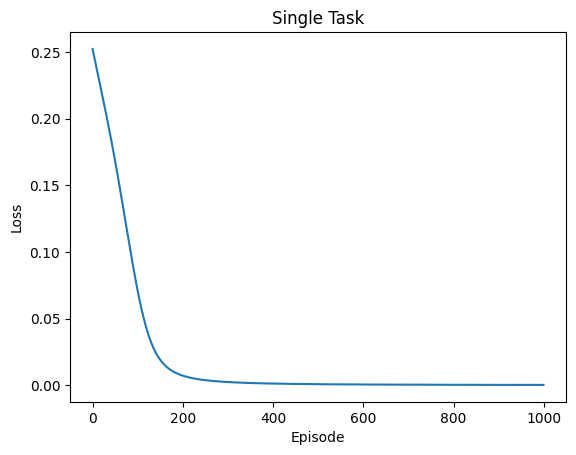

In [ ]:
plot_losses(Loss_reinforce,'Single Task')

In [ ]:
def evaluate(model, val_task, val_stimulus, val_target):
    model.eval()
    with torch.no_grad():
        _, val_output = model(val_task, val_stimulus)
        criterion = nn.MSELoss()
        val_loss = criterion(val_output, val_target).item()

    model.train()
    return val_loss

In [ ]:
evaluate(model, val_task, val_stimulus, val_target)

0.8804306387901306

In [ ]:
def run_simulations(n_simulations=100, config=None):
    all_losses = []

    for _ in tqdm(range(n_simulations)):
        model = Model()
        training_set, validation_set = generate_dataset_singletask(split_ratio=0.8)
        taskData, stimulusData, targetData = training_set


        if config == 'singletask_reinforcement':
            loss_log = train_Rein(model, taskData, stimulusData, targetData, num_episodes=1000)

        all_losses.append(loss_log)

    return all_losses

In [ ]:
def calculate_mean_and_standard_error(all_losses):
    min_length = min(len(loss) for loss in all_losses)
    trimmed_losses = [loss[:min_length] for loss in all_losses]
    losses_array = numpy.array(trimmed_losses)
    mean_losses = numpy.mean(losses_array, axis=0)
    std_err_losses = numpy.std(losses_array, axis=0) / numpy.sqrt(losses_array.shape[0])
    return mean_losses, std_err_losses

def plot_learning_curve_with_standard_error(mean_losses, std_err_losses, title):
    epochs = range(len(mean_losses))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mean_losses, label='Mean Loss', linewidth=2)
    # Scaling the standard error for visibility; here we multiply by 10 for example purposes
    visible_std_err_losses = std_err_losses * 100
    plt.fill_between(epochs, mean_losses - visible_std_err_losses, mean_losses + visible_std_err_losses, color='b', alpha=0.3, label='Standard Error (Scaled)')
    plt.xlabel('Epochs / Episodes')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{title.replace(" ", "_").lower()}_learning_curve_with_standard_error.png')
    plt.show()


In [ ]:
all_losses_reinforce = run_simulations(n_simulations=100, config='singletask_reinforcement')

  0%|          | 0/100 [00:00<?, ?it/s]

Episode 5/1000 | Loss: 0.217
Episode 10/1000 | Loss: 0.208
Episode 15/1000 | Loss: 0.200
Episode 20/1000 | Loss: 0.191
Episode 25/1000 | Loss: 0.182
Episode 30/1000 | Loss: 0.174
Episode 35/1000 | Loss: 0.165
Episode 40/1000 | Loss: 0.156
Episode 45/1000 | Loss: 0.146
Episode 50/1000 | Loss: 0.137
Episode 55/1000 | Loss: 0.128
Episode 60/1000 | Loss: 0.118
Episode 65/1000 | Loss: 0.109
Episode 70/1000 | Loss: 0.100
Episode 75/1000 | Loss: 0.091
Episode 80/1000 | Loss: 0.082
Episode 85/1000 | Loss: 0.073
Episode 90/1000 | Loss: 0.065
Episode 95/1000 | Loss: 0.058
Episode 100/1000 | Loss: 0.051
Episode 105/1000 | Loss: 0.045
Episode 110/1000 | Loss: 0.040
Episode 115/1000 | Loss: 0.035
Episode 120/1000 | Loss: 0.030
Episode 125/1000 | Loss: 0.027
Episode 130/1000 | Loss: 0.023
Episode 135/1000 | Loss: 0.021
Episode 140/1000 | Loss: 0.018
Episode 145/1000 | Loss: 0.016
Episode 150/1000 | Loss: 0.015
Episode 155/1000 | Loss: 0.013
Episode 160/1000 | Loss: 0.012
Episode 165/1000 | Loss: 0.0

  1%|          | 1/100 [00:01<02:35,  1.57s/it]

Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.222
Episode 10/1000 | Loss: 0.214
Episode 15/1000 | Loss: 0.205
Episode 20/1000 | Loss: 0.196
Episode 25/1000 | Loss: 0.188
Episode 30/1000 | Loss: 0.179
Episode 35/1000 | Loss: 0.170
Episode 40/1000 | Loss: 0.161
Episode 45/1000 | Loss: 0.152
Episode 50/1000 | Loss: 0.142
Episode 55/1000 | Loss: 0.133
Episode 60/1000 | Loss: 0.123
Episode 65/1000 | Loss: 0.113
Episode 70/1000 | Loss: 0.104
Episode 75/1000 | Loss: 0.095
Episode 80/1000 | Loss: 0.085
Episode 85/1000 | Loss: 0.077
Episode 90/1000 | Loss: 0.068
Episode 95/1000 | Loss: 0.061
Episode 100/1000 | Loss: 0.053
Episode 105/1000 | Loss: 0.

  2%|▏         | 2/100 [00:03<02:56,  1.80s/it]

Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.241
Episode 10/1000 | Loss: 0.231
Episode 15/1000 | Loss: 0.222
Episode 20/1000 | Loss: 0.213
Episode 25/1000 | Loss: 0.204
Episode 30/1000 | Loss: 0.195
Episode 35/1000 | Loss: 0.185
Episode 40/1000 | Loss: 0.176
Episode 45/1000 | Loss: 0.166
Episode 50/1000 | Loss: 0.156
Episode 55/1000 | Loss: 0.146
Episode 60/1000 | Loss: 0.136
Episode 65/1000 | Loss: 0.125
Episode 70/1000 | Loss: 0.115
Episode 75/1000 | Loss: 0.105
Episode 80/1000 | Loss:

  3%|▎         | 3/100 [00:05<02:56,  1.82s/it]

Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.227
Episode 10/1000 | Loss: 0.218
Episode 15/1000 | Loss: 0.209
Episode 20/1000 | Loss: 0.200
Episode 25/1000 | Loss: 0.191
Episode 30/1000 | Loss: 0.182
Episode 35/1000 | Loss: 0.173
Episode 40/1000 | Loss: 0.163
Episode 45/1000 | Loss: 0.154
Episode 50/1000 | Loss: 0.144
Episode 55/1000 | Loss: 0.134
Episode 60/1000 | Loss: 0.124
Episode 65/1000 | Loss: 0.114
Episode 70/1000 | Los

  4%|▍         | 4/100 [00:06<02:45,  1.72s/it]

Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.231
Episode 10/1000 | Loss: 0.222
Episode 15/1000 | Loss: 0.214
Episode 20/1000 | Loss: 0.205
Episode 25/1000 | Loss: 0.196
Episode 30/1000 | Loss: 0.188
Episode 35/1000 | Loss: 0.179
Episode 40/1000 | Loss: 0.170
Episode 45/1000 | Loss: 0.161
Episode 50/1000 | Loss: 0.151
Episode 55/1000 | Loss: 0.142
Episode 60/1000 | Loss: 0.132
Episode 65/1000 | Loss: 0.123
Episode 70/1000 | Loss: 0.113
Episode 75/1000 | Loss: 0.104
Episode 80/1000 | Loss: 0.094
Episode 85/1000 | Loss: 0.085
Episode 90/1000 | Loss: 0.076
Episode 95/1000 | Loss: 0.068
Episode 100/1000 | Loss: 0.060
Episode 105/1000 | Loss: 0.053
Episode 110/1000 | Loss: 0.047
Episode 115/1000 | Loss: 0.041
Episode 120/1000 | Loss: 0.036
Episode 125/1000 | Loss: 0.

  5%|▌         | 5/100 [00:08<02:38,  1.67s/it]

Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.242
Episode 10/1000 | Loss: 0.233
Episode 15/1000 | Loss: 0.224
Episode 20/1000 | Loss: 0.215
Episode 25/1000 | Loss: 0.205
Episode 30/1000 | Loss: 0.196
Episode 35/1000 | Loss: 0.187
Episode 40/1000 | Loss: 0.177
Episode 45/1000 | Loss: 0.167
Episode 50/1000 | Loss: 0.157
Episode 55/1000 | 

  6%|▌         | 6/100 [00:10<02:33,  1.64s/it]

Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.227
Episode 10/1000 | Loss: 0.218
Episode 15/1000 | Loss: 0.209
Episode 20/1000 | Loss: 0.200
Episode 25/1000 | Loss: 0.191
Episode 30/1000 | Loss: 0.182
Episode 35/1000 | Loss: 0.173
Episode 40/1000 | Loss: 0.164
Episode 45/1000 | Loss: 0.154
Episode 50/1000 | Loss: 0.144
Episode 55/1000 | Loss: 0.134
Episode 60/1000 | Loss: 0.125
Episode 65/1000 | Loss: 0.115
Episode 70/1000 | Loss: 0.105
Episode 75/1000 | Loss: 0.095
Episode 80/1000 | Loss: 0.086
Episode 85/1000 | Loss: 0.077
Episode 90/1000 | Loss: 0.068
Episode 95/1000 | Loss: 0.060
Episode 100/1000 | Loss: 0.053
Episode 105/1000 | Loss: 0.

  7%|▋         | 7/100 [00:11<02:30,  1.61s/it]

Episode 870/1000 | Loss: 0.000
Episode 875/1000 | Loss: 0.000
Episode 880/1000 | Loss: 0.000
Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.219
Episode 10/1000 | Loss: 0.210
Episode 15/1000 | Loss: 0.202
Episode 20/1000 | Loss: 0.193
Episode 25/1000 | Loss: 0.184
Episode 30/10

  8%|▊         | 8/100 [00:13<02:27,  1.60s/it]

Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.240
Episode 10/1000 | Loss: 0.231
Episode 15/1000 | Loss: 0.222
Episode 20/1000 | Loss: 0.213
Episode 25/1000 | Loss: 0.204
Episode 30/1000 | Loss: 0.195
Episode 35/1000 | Loss: 0.185
Episode 40/1000 | Loss: 0.176
Episode 45/1000 | Loss: 0.166
Episode 50/1000 | Loss: 0.156
Episode 55/1000 | Loss: 0.146
Episode 60/1000 | Loss: 0.136
Episode 65/1000 | Loss: 0.126
Episode 70/1000 | Loss: 0.115
Episode 75/1000 | Loss: 0.105
Episode 80/1000 | Loss: 0.095
Episode 85/1000 | Loss: 0.086
Episode 90/1000 | Loss: 0.077
Episode 95/1000 | Loss: 0.068
Episode 100/1000 | Loss: 0.060
Episode 105/1000 | Loss: 0.053
Episode 110/1000 | Loss: 0.

  9%|▉         | 9/100 [00:14<02:28,  1.63s/it]

Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.236
Episode 10/1000 | Loss: 0.227
Episode 15/1000 | Loss: 0.219
Episode 20/1000 | Loss: 0.210
Episode 25/1000 | Loss: 0.201
Episode 30/1000 | Loss: 0.192
Episode 35/1000 | Loss: 0.183
Episode 40/1000 | Loss: 0.173
Episode 45/1000 | Loss: 0.164
Episode 50/1000 | Loss: 0.154
Episode 55/1000 | Loss: 0.144
Episode 60/1000 | Loss: 0.134
Episode 65/1000 | Loss: 0.124
Episode 70/1000 | Loss: 0.114
Episode 75/1000 | Loss: 0.104
Episode 80/1000 | Loss: 0.094
Episode 85/1000 | Loss: 0.085
Episode 90/1000 | Loss: 0.076
Episode 95/1000 | Loss: 0.067
Episode 100/1000 | Loss: 0.

 10%|█         | 10/100 [00:17<02:41,  1.79s/it]


Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.223
Episode 10/1000 | Loss: 0.214
Episode 15/1000 | Loss: 0.206
Episode 20/1000 | Loss: 0.197
Episode 25/1000 | Loss: 0.188
Episode 30/1000 | Loss: 0.179
Episode 35/1000 | Loss: 0.170
Episode 40/1000 | Loss: 0.161
Episode 45/1000 | Loss: 0.152
Episode 50/1000 | Loss: 0.142
Episode 55/1000 | Loss: 0.133
Episode 60/1000 | Loss: 0.123
Episode 65/1000 | L

 11%|█         | 11/100 [00:18<02:33,  1.72s/it]

Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.227
Episode 10/1000 | Loss: 0.218
Episode 15/1000 | Loss: 0.210
Episode 20/1000 | Loss: 0.201
Episode 25/1000 | Loss: 0.192
Episode 30/1000 | Loss: 0.184
Episode 35/1000 | Loss: 0.175
Episode 40/1000 | Loss: 0.166
Episode 45/1000 | Loss: 0.157
Episode 50/1000 | Loss: 0.147
Episode 55/1000 | Loss: 0.138
Episode 60/1000 | Loss: 0.128
Episode 65/1000 | Loss: 0.119
Episode 70/1000 | Loss: 0.109
Episode 75/1000 | Loss: 0.100
Episode 80/1000 | Loss: 0.091
Episode 85/1000 | Loss: 0.082
Episode 90/1000 | Loss: 0.073
Episode 95/1000 | Loss: 0.065
Episode 100/1000 | Loss: 0.058
Episode 105/1000 | Loss: 0.

 12%|█▏        | 12/100 [00:20<02:27,  1.68s/it]

Episode 870/1000 | Loss: 0.000
Episode 875/1000 | Loss: 0.000
Episode 880/1000 | Loss: 0.000
Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.234
Episode 10/1000 | Loss: 0.225
Episode 15/1000 | Loss: 0.216
Episode 20/1000 | Loss: 0.207
Episode 25/1000 | Loss: 0.198
Episode 30/10

 13%|█▎        | 13/100 [00:21<02:23,  1.65s/it]

Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.227
Episode 10/1000 | Loss: 0.218
Episode 15/1000 | Loss: 0.209
Episode 20/1000 | Loss: 0.200
Episode 25/1000 | Loss: 0.191
Episode 30/1000 | Loss: 0.182
Episode 35/1000 | Loss: 0.173
Episode 40/1000 | Loss: 0.164
Episode 45/1000 | Loss: 0.154
Episode 50/1000 | Loss: 0.145
Episode 55/1000 | Loss: 0.135
Episode 60/1000 | Loss: 0.125
Episode 65/1000 | Loss: 0.115
Episode 70/1000 | Loss: 0.106
Episode 75/1000 | Loss: 0.096
Episode 80/1000 | Loss: 0.087
Episode 85/1000 | Loss: 0.078
Episode 90/1000 | Loss: 0.069
Episode 95/1000 | Loss: 0.061
Episode 100/1000 | Loss: 0.

 14%|█▍        | 14/100 [00:23<02:19,  1.63s/it]

Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.242
Episode 10/1000 | Loss: 0.233
Episode 15/1000 | Loss: 0.224
Episode 20/1000 | Loss: 0.216
Episode 25/1000 | Loss: 0.207
Episode 30/1000 | Loss: 0.198
Episode 35/1000 | Loss: 0.189
Episode 40/1000 | Loss: 0.180
Episode 45/1000 | Loss: 0.170
Episode 50/1000 | Loss: 0.161
Episode 55/1000 | Loss: 0.151
Episode 60/1000 | Loss: 0.141
Episode 65/1000 | Loss: 0.131
Episode 70/1000 | Loss: 0.121
Episode 75/1000 | Loss: 0.111
Episode 80/1000 | Loss: 0.100
Episode 85/1000 | Loss: 0.091
Episode 90/1000 | Loss: 0.081
Episode 95/1000 | Loss: 0.072
Episode 100/1000 | Loss: 0.064
Episode 105/1000 | Loss: 0.056
Episode 110/1000 | Loss: 0.049
Episode 115/1000 | Loss: 0.043
Episode 120/1000 | Loss: 0.038
Episode 125/1000 | Loss: 0.033
Episode 130/1000 | Loss: 0.029
Episode 135/1000 | Loss: 0.025
Episode 140/1000 | Loss: 0.022
Episode 145/1000 | Loss: 0.019
Episode 150/1000 | Loss: 0.017
Episode 155/1000 | Loss: 0.015
Episode 160/1000 | Loss: 0.

 15%|█▌        | 15/100 [00:24<02:17,  1.62s/it]

Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.228
Episode 10/1000 | Loss: 0.219
Episode 15/1000 | Loss: 0.210
Episode 20/1000 | Loss: 0.201
Episode 25/1000 | Loss: 0.192
Episode 30/1000 | Loss: 0.183
Episode 35/1000 | Loss: 0.173
Episode 40/1000 | Loss: 0.164
Episode 45/1000 | Loss: 0.154
Episode 50/1000 | Loss: 0.145
Episode 55/1000 | Loss: 0.135
Episode 60/1000 | Loss: 0.125
Episode 65/1000 | Loss: 0.115
Episode 70/1000 | Loss: 0.105
Episode 75/1000 | Loss

 16%|█▌        | 16/100 [00:26<02:15,  1.61s/it]

Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.226
Episode 10/1000 | Loss: 0.217
Episode 15/1000 | Loss: 0.208
Episode 20/1000 | Loss: 0.199
Episode 25/1000 | Loss: 0.190
Episode 30/1000 | Loss: 0.181
Episode 35/1000 | Loss: 0.172
Episode 40/1000 | Loss: 0.163
Episode 45/1000 | Loss: 0.154
Episode 50/1000 | Loss: 0.145
Episode 55/1000 | Loss: 0.135
Episode 60/1000 | Loss: 0.125
Episode 65/1000 | Loss: 0.116
Episode 70/1000 | Loss: 0.106
Episode 75/1000 | Loss: 0.097
Episode 80/1000 | Loss: 0.087
Episode 85/1000 | Loss: 0.078
Episode 90/1000 | Loss: 0.070
Episode 95/1000 | Loss: 0.062
Episode 100/1000 | Loss: 0.055
Episode 105/1000 | Loss: 0.

 17%|█▋        | 17/100 [00:28<02:23,  1.72s/it]

Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.241
Episode 10/1000 | Loss: 0.233
Episode 15/1000 | Loss: 0.224
Episode 20/1000 | Loss: 0.215
Episode 25/1000 | Loss: 0.206
Episode 30/1000 | Loss: 0.196
Episode 35/1000 | Loss: 0.187
Episode 40/1000 | Loss: 0.178
Episode 45/1000 | Loss: 0.168
Episode 50/1000 | Loss: 0.158
Episode 55/1000 | Loss: 0.148
Episode 60/1000 | Loss: 0.138
Episode 65/1000 | Loss: 0.127
Episode 70/1000 | Los

 18%|█▊        | 18/100 [00:30<02:24,  1.76s/it]

Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.232
Episode 10/1000 | Loss: 0.223
Episode 15/1000 | Loss: 0.214
Episode 20/1000 | Loss: 0.205
Episode 25/1000 | Loss: 0.196
Episode 30/1000 | Loss: 0.187
Episode 35/1000 | Loss: 0.178
Episode 40/1000 | Loss: 0.168
Episode 45/1000 | Loss: 0.159
Episode 50/1000 | Loss: 0.149
Episode 55/1000 | Loss: 0.139
Episode 60/1000 | Loss: 0.129
Episode 65/1000 | Loss: 0.119
Episode 70/1000 | Los

 19%|█▉        | 19/100 [00:31<02:18,  1.70s/it]

Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.237
Episode 10/1000 | Loss: 0.228
Episode 15/1000 | Loss: 0.219
Episode 20/1000 | Loss: 0.210
Episode 25/1000 | Loss: 0.201
Episode 30/1000 | Loss: 0.192
Episode 35/1000 | Loss: 0.183
Episode 40/1000 | Loss: 0.173
Episode 45/1000 | Loss: 0.163
Episode 50/1000 | Loss: 0.154
Episode 55/1000 | Loss: 0.144
Episode 60/1000 | Loss: 0.133
Episode 65/1000 | Loss: 0.123
Episode 70/1000 | Loss: 0.113
Episode 75/1000 | Loss: 0.103
Episode 80/1000 | Loss: 0.093
Episode 85/1000 | Loss: 0.084
Episode 90/1000 | Loss: 0.075
Episode 95/1000 | Loss: 0.066
Episode 100/1000 | Loss: 0.058
Episode 105/1000 | Loss: 0.051
Episode 110/1000 | Loss: 0.045
Episode 115/1000 | Loss: 0.039
Episode 120/1000 | Loss: 0.

 20%|██        | 20/100 [00:33<02:13,  1.67s/it]

Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.229
Episode 10/1000 | Loss: 0.220
Episode 15/1000 | Loss: 0.211
Episode 20/1000 | Loss: 0.202
Episode 25/1000 | Loss: 0.194
Episode 30/1000 | Loss: 0.185
Episode 35/1000 | Loss: 0.175
Episode 40/1000 | Loss: 0.166
Episode 45/1000 | Loss: 0.157
Episode 50/1000 |

 21%|██        | 21/100 [00:35<02:09,  1.64s/it]

Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.219
Episode 10/1000 | Loss: 0.211
Episode 15/1000 | Loss: 0.202
Episode 20/1000 | Loss: 0.193
Episode 25/1000 | Loss: 0.184
Episode 30/1000 | Loss: 0.175
Episode 35/1000 | Loss: 0.166
Episode 40/1000 | Loss: 0.157
Episode 45/1000 | Loss: 0.148
Episode 50/1000 | Loss: 0.138
Episode 55/1000 | Loss: 0.129
Episode 60/1000 | Loss: 0.119
Episode 65/1000 | Loss: 0.110
Episode 70/1000 | Loss: 0.101
Episode 75/1000 | Loss: 0.091
Episode 80/1000 | Loss: 0.083
Episode 85/1000 | Loss: 0.074
Episode 90/1000 | Loss: 0.066
Episode 95/1000 | Loss: 0.059
Episode 100/1000 | Loss: 0.052
Episode 105/1000 | Loss: 0.045
Episode 110/1000 | Loss: 0.

 22%|██▏       | 22/100 [00:36<02:06,  1.62s/it]

Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.226
Episode 10/1000 | Loss: 0.217
Episode 15/1000 | Loss: 0.209
Episode 20/1000 | Loss: 0.200
Episode 25/1000 | Loss: 0.192
Episode 30/1000 | Loss: 0.183
Episode 35/1000 | Loss: 0.174
Episode 40/1000 | Loss: 0.165
Episode 45/1000 

 23%|██▎       | 23/100 [00:38<02:04,  1.62s/it]

Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.236
Episode 10/1000 | Loss: 0.227
Episode 15/1000 | Loss: 0.219
Episode 20/1000 | Loss: 0.210
Episode 25/1000 | Loss: 0.201
Episode 30/1000 | Loss: 0.192
Episode 35/1000 | Loss: 0.183
Episode 40/1000 | Loss: 0.174
Episode 45/1000 | Loss: 0.165
Episode 50/1000 | Loss: 0.156
Episode 55/1000 | Loss: 0.146
Episode 60/1000 | Loss: 0.136
Episode 65/1000 | Loss: 0.126
Episode 70/1000 | Loss: 0.117
Episode 75/1000 | Loss: 0.107
Episode 80/1000 | Loss: 0.097
Episode 85/1000 | Loss: 0.088
Episode 90/1000 | Loss: 0

 24%|██▍       | 24/100 [00:40<02:07,  1.67s/it]


Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.223
Episode 10/1000 | Loss: 0.214
Episode 15/1000 | Loss: 0.205
Episode 20/1000 | Loss: 0.196
Episode 25/1000 | Loss: 0.187
Episode 30/1000 | Loss: 0.178
Episode 35/1000 | Loss: 0.168
Episode 40/1000 | Loss: 0.159
Episode 45/1000 | Loss: 0.150
Episode 50/1000 | Loss: 0.140
Episode 55/1000 | Loss: 0.131
Episode 60/1000 | Loss: 0.121
Episode 65/1000 | Loss: 0.111
Episode 70/1000 | Loss: 0.102
Episode 75/1000 | Loss: 0.092
Episode 80/1000 | Loss: 0.083
Episode 85/1000 | Loss: 0.075
Episode 90/1000 | Loss: 0.066
Episode 95/1000 | Loss: 0.059
Episode 100/1000 | Loss: 0.052
Episode 105/1000 | Loss: 0.046
Episode 110/1000 | Loss: 0.040
Episode 115/1000 | Loss: 0.035
Episode 120/1000 | Loss: 0.031
Episode 125/1000 | Loss: 0.027
Episode 130/1000 | Loss: 0.024
Episode 135/1000 | Loss: 0.021
Episode 140/1000 | Loss: 0.018
Episode 145/1000 | Loss: 0.016
Episode 150/1000 | Loss: 0

 25%|██▌       | 25/100 [00:42<02:14,  1.79s/it]

Episode 880/1000 | Loss: 0.000
Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.240
Episode 10/1000 | Loss: 0.232
Episode 15/1000 | Loss: 0.223
Episode 20/1000 | Loss: 0.214
Episode 25/1000 | Loss: 0.205
Episode 30/1000 | Loss: 0.196
Episode 35/1000 | Loss: 0.186
Episode 40/1000

 26%|██▌       | 26/100 [00:43<02:07,  1.72s/it]

Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.232
Episode 10/1000 | Loss: 0.223
Episode 15/1000 | Loss: 0.215
Episode 20/1000 | Loss: 0.206
Episode 25/1000 | Loss: 0.197
Episode 30/1000 | Loss: 0.188
Episode 35/1000 | Loss: 0.179
Episode 40/1000 | Loss: 0.169
Episode 45/1000 | Loss: 0.160
Episode 50/1000 | Loss: 0.150
Episode 55/1000 | Loss: 0.140
Episode 60/1000 | Loss: 0.130
Episode 65/1000 | Loss: 0.120
Episode 70/1000 | Loss: 0.110
Episode 75/1000 | Loss: 0.101
Episode 80/1000 | Loss: 0.091
Episode 85/1000 | Loss: 0.082
Episode 90/1000 | Loss: 0.073
Episode 95/1000 | Loss: 0.065
Episode 100/1000 | Loss: 0.057
Episode 105/1000 | Loss: 0.050
Episode 110/1000 | Loss: 0.

 27%|██▋       | 27/100 [00:45<02:02,  1.68s/it]

Episode 865/1000 | Loss: 0.000
Episode 870/1000 | Loss: 0.000
Episode 875/1000 | Loss: 0.000
Episode 880/1000 | Loss: 0.000
Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.234
Episode 10/1000 | Loss: 0.225
Episode 15/1000 | Loss: 0.216
Episode 20/1000 | Loss: 0.207
Episode 25/1

 28%|██▊       | 28/100 [00:46<01:59,  1.66s/it]

Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.224
Episode 10/1000 | Loss: 0.215
Episode 15/1000 | Loss: 0.206
Episode 20/1000 | Loss: 0.198
Episode 25/1000 | Loss: 0.189
Episode 30/1000 | Loss: 0.180
Episode 35/1000 | Loss: 0.171
Episode 40/1000 | Loss: 0.162
Episode 45/1000 | Loss: 0.153
Episode 50/1000 | Loss: 0.144
Episode 55/1000 | Loss: 0.134
Episode 60/1000 | Loss: 0.125
Episode 65/1000 | Loss: 0.115
Episode 70/1000 | Loss: 0.105
Episode 75/1000 | Loss: 0.096
Episode 80/1000 | Loss: 0.087
Episode 85/1000 | Loss: 0.078
Episode 90/1000 | Loss: 0.070
Episode 95/1000 | Loss: 0.

 29%|██▉       | 29/100 [00:49<02:06,  1.78s/it]

Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.219
Episode 10/1000 | Loss: 0.210
Episode 15/1000 | Loss: 0.201
Episode 20/1000 | Loss: 0.193
Episode 25/1000 | Loss: 0.184
Episode 30/1000 | Loss: 0.175
Episode 35/1000 | Loss: 0.166
Episode 40/1000 | Loss: 0.157
Episode 45/1000 | Loss: 0.148
Episode 50/1000 | Loss: 0.138
Episode 55/1000 | Loss: 0.129
Episode 60/1000 | Loss: 0.119
Episode 65/1000 | Loss: 0.110
Episode 70/1000 | Loss: 0.101
Episode 75/1000 | Loss: 0.091
Episode 80/1000 | Loss: 0.082
Episode 85/1000 | Loss: 0.074
Episode 90/1000 | Loss: 0.066
Episode 95/1000 | Loss: 0.058
Episode 100/1000 | Loss: 0.052
Episode 105/1000 | Loss: 0.045
Episode 110/1000 | Loss: 0.040
Episode 115/1000 | Loss: 0.035
Episode 120/1000 | Loss: 0.031
Episode 125/1000 | Loss: 0.027
Episode 130/1000 | Loss: 0.024
Episode 135/1000 | Loss: 0.021
Episode 140/1000 | Loss: 0.018
Episode 145/1000 | Loss: 0.016
Episode 150/1000 | Loss: 0.015
Episode 155/1000 | Loss: 0.013
Episode 160/1000 | Loss: 0.

 30%|███       | 30/100 [00:50<02:04,  1.78s/it]

Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.230
Episode 10/1000 | Loss: 0.221
Episode 15/1000 | Loss: 0.212
Episode 20/1000 | Loss: 0.203
Episode 25/1000 | Loss: 0.194
Episode 30/1000 | Loss: 0.185
Episode 35/1000 | Loss: 0.175
Episode 40/1000 | Loss: 0.166
Episode 45/1000 | Loss: 0.156
Episode 50/1000 | Loss: 0.147
Episode 55/1000 | Loss: 0.137
Episode 60/1000 | Loss: 0.127
Episode 65/1000 | Loss: 0.117
Episode 70/1000 | Los

 31%|███       | 31/100 [00:52<02:02,  1.78s/it]

Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.235
Episode 10/1000 | Loss: 0.225
Episode 15/1000 | Loss: 0.216
Episode 20/1000 | Loss: 0.207
Episode 25/1000 | Loss: 0.198
Episode 30/1000 | Loss: 0.189
Episode 35/1000 | Loss: 0.179
Episode 40/1000 | Loss: 0.170
Episode 45/1000 | Loss: 0.160
Episode 50/1000 | Loss: 0.150
Episode 55/1000 | Loss: 0.140
Episode 60/1000 | Loss: 0.130
Episode 65/1000 | Loss: 0.120
Episode 70/1000 | Loss: 0.110
Episode 75/1000 | Loss: 0.100
Episode 80/1000 | Loss: 0.090
Episode 85/1000 | Loss: 0.081
Episode 90/1000 | Loss: 0.072
Episode 95/1000 | Loss: 0.064
Episode 100/1000 | Loss: 0.056
Episode 105/1000 | Loss: 0.050
Episode 110/1000 | Loss: 0.043
Episode 115/1000 | Loss: 0.038
Episode 120/1000 | Loss: 0.033
Episode 125/1000 | Loss: 0.029
Episode 130/1000 | Loss: 0.025
Episode 135/1000 | Loss: 0.022
Episode 140/1000 | Loss: 0.020
Episode 145/1000 | Loss: 0.018
Episode 150/1000 | Loss: 0.016
Episode 155/1000 | Loss: 0.

 32%|███▏      | 32/100 [00:54<02:06,  1.86s/it]

Episode 870/1000 | Loss: 0.000
Episode 875/1000 | Loss: 0.000
Episode 880/1000 | Loss: 0.000
Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.224
Episode 10/1000 | Loss: 0.215
Episode 15/1000 | Loss: 0.207
Episode 20/1000 | Loss: 0.198
Episode 25/1000 | Loss: 0.189
Episode 30/10

 33%|███▎      | 33/100 [00:56<01:58,  1.77s/it]

Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.223
Episode 10/1000 | Loss: 0.214
Episode 15/1000 | Loss: 0.205
Episode 20/1000 | Loss: 0.196
Episode 25/1000 | Loss: 0.187
Episode 30/1000 | Loss: 0.178
Episode 35/1000 | Loss: 0.169
Episode 40/1000 | Loss: 0.160
Episode 45/1000 | Loss: 0.151
Episode 50/1000 | Loss: 0.141
Episode 55/1000 | Loss: 0.131
Episode 60/1000 | Loss: 0.122
Episode 65/1000 | Loss: 0.112
Episode 70/1000 | Loss: 0.103
Episode 75/1000 | Loss: 0.094
Episode 80/1000 | Loss: 0.085
Episode 85/1000 | Loss: 0.076
Episode 90/1000 | Loss: 0.068
Episode 95/1000 | Loss: 0.060
Episode 100/1000 | Loss: 0.053
Episode 105/1000 | Loss: 0.047
Episode 110/1000 | Loss: 0.041
Episode 115/1000 | Loss: 0.036
Episode 120/1000 | Loss: 0.031
Episode 125/1000 | Loss: 0.

 34%|███▍      | 34/100 [00:57<01:52,  1.71s/it]

Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.234
Episode 10/1000 | Loss: 0.225
Episode 15/1000 | Loss: 0.216
Episode 20/1000 | Loss: 0.207
Episode 25/1000 | Loss: 0.197
Episode 30/1000 | Loss: 0.188
Episode 35/1000 | Loss: 0.179
Episode 40/1000 | Loss: 0.169
Episode 45/1000 | Loss: 0.159
Episode 50/1000 | Loss: 0.149
Episode 55/1000 | Loss: 0.139
Episode 60/1000 | L

 35%|███▌      | 35/100 [00:59<01:48,  1.67s/it]

Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.231
Episode 10/1000 | Loss: 0.222
Episode 15/1000 | Loss: 0.213
Episode 20/1000 | Loss: 0.205
Episode 25/1000 | Loss: 0.196
Episode 30/1000 | Loss: 0.187
Episode 35/1000 | Loss: 0.178
Episode 40/1000 | Loss: 0.169
Episode 45/1000 | Loss: 0.160
Episode 50/1000 | Loss: 0.150
Episode 55/1000 | Loss: 0.141
Episode 60/1000 | Loss: 0.131
Episode 65/1000 | Loss: 0.122
Episode 70/1000 | Loss: 0.112
Episode 75/1000 | Loss: 0.103
Episode 80/1000 | Loss: 0.093
Episode 85/1000 | Loss: 0.084
Episode 90/1000 | Loss: 0.075
Episode 95/1000 | Loss: 0.067
Episode 100/1000 | Loss: 0.060
Episode 105/1000 | Loss: 0.053
Episode 110/1000 | Loss: 0.046
Episode 115/1000 | Loss: 0.041
Episode 120/1000 | Loss: 0.035
Episode 125/1000 | Loss: 0.031
Episode 130/1000 | Loss: 0.027
Episode 135/1000 | Loss: 0.

 36%|███▌      | 36/100 [01:00<01:45,  1.65s/it]

Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.224
Episode 10/1000 | Loss: 0.215
Episode 15/1000 | Loss: 0.206
Episode 20/1000 | Loss: 0.198
Episode 25/1000 | Loss: 0.189
Episode 30/1000 | Loss: 0.180
Episode 35/1000 | Loss: 0.171
Episode 40/1000 | Loss: 0.161
Episode 45/1000 | Loss: 0.152
Episode 50/1000 |

 37%|███▋      | 37/100 [01:02<01:42,  1.62s/it]

Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.231
Episode 10/1000 | Loss: 0.222
Episode 15/1000 | Loss: 0.213
Episode 20/1000 | Loss: 0.204
Episode 25/1000 | Loss: 0.195
Episode 30/1000 | Loss: 0.186
Episode 35/1000 | Loss: 0.177
Episode 40/1000 | Loss: 0.168
Episode 45/1000 | Loss: 0.158
Episode 50/1000 | Loss: 0.148
Episode 55/1000 | Loss: 0.139
Episode 60/1000 | Loss: 0.129
Episode 65/1000 | Loss: 0.119
Episode 70/1000 | Loss: 0.109
Episode 75/1000 | Loss: 0.099
Episode 80/1000 | Loss: 0.090
Episode 85/1000 | Loss: 0.081
Episode 90/1000 | Loss: 0.072
Episode 95/1000 | Loss: 0.064
Episode 100/1000 | Loss: 0.057
Episode 105/1000 | Loss: 0.050
Episode 110/1000 | Loss: 0.044
Episode 115/1000 | Loss: 0.

 38%|███▊      | 38/100 [01:04<01:39,  1.60s/it]

Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.226
Episode 10/1000 | Loss: 0.218
Episode 15/1000 | Loss: 0.209
Episode 20/1000 | Loss: 0.200
Episode 25/1000 | Loss: 0.192
Episode 30/1000 | Loss: 0.183
Episode 35/1000 | Loss: 0.174
Episode 40/1000 | Loss: 0.165
Episode 45/1000 | Loss: 0.156
Episode 50/1000 | Loss: 0.147
Episode 55/1000 | Loss: 0.138
Episode 60/1000 | L

 39%|███▉      | 39/100 [01:06<01:45,  1.73s/it]

Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.229
Episode 10/1000 | Loss: 0.220
Episode 15/1000 | Loss: 0.211
Episode 20/1000 | Loss: 0.202
Episode 25/1000 | Loss: 0.193
Episode 30/1000 | Loss: 0.184
Episode 35/1000 | Loss: 0.175
Episode 40/1000 | Loss: 0.165
Episode 45/1000 | Loss: 0.156
Episode 50/1000 | Loss: 0.146
Episode 55/1000 | Loss: 0.136
Episode 60/1000 | Loss: 0.126
Episode 65/1000 | Loss: 0.117
Episode 70/1000 | Loss: 0.107
Episode 75/1000 | Loss: 0.097
Episode 80/1000 | Loss: 0.088
Episode 85/1000 | Loss: 0.079
Episode 90/1000 | Loss: 0.070
Episode 95/1000 | Loss: 0.062
Episode 100/1000 | Loss: 0.055
Episode 105/1000 | Loss: 0.048
Episode 110/1000 | Loss: 0.042
Episode 115/1000 | Loss: 0.

 40%|████      | 40/100 [01:07<01:45,  1.76s/it]

Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.236
Episode 10/1000 | Loss: 0.227
Episode 15/1000 | Loss: 0.218
Episode 20/1000 | Loss: 0.209
Episode 25/1000 | Loss: 0.200
Episode 30/1000 | Loss: 0.191
Episode 35/1000 | Loss: 0.181
Episode 40/1000 | Loss: 0.172
Episode 45/1000 | Loss: 0.162
Episode 50/1000 | Loss: 0.152
Episode 55/1000 | Loss: 0.142
Episode 60/1000 | Loss: 0.132
Episode 65/1000 | Loss: 0.122
Episode 70/1000 | Loss: 0.111
Episode 75/1000 | Loss: 0.101
Episode 80/1000 | Loss: 0.092
Episode 85/1000 | Loss: 0.082
Episode 90/1000 | Loss: 0.073
Episode 95/1000 | Loss: 0.065
Episode 100/1000 | Loss: 0.057
Episode 105/1000 | Loss: 0.050
Episode 110/1000 | Loss: 0.044
Episode 115/1000 | Loss: 0.038
Episode 120/1000 | Loss: 0.034
Episode 125/1000 | Loss: 0.029
Episode 130/1000 | Loss: 0.026
Episode 135/1000 | Loss: 0.023
Episode 140/1000 | Loss: 0.020
Episode 145/1000 | Loss: 0.018
Episode 150/1000 | Loss: 0.016
Episode 155/1000 | Loss: 0.014
Episode 160/1000 | Loss: 0.

 41%|████      | 41/100 [01:09<01:40,  1.70s/it]

Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.225
Episode 10/1000 | Loss: 0.216
Episode 15/1000 | Loss: 0.208
Episode 20/1000 | Loss: 0.199
Episode 25/1000 | Loss: 0.190
Episode 30/1000 | Loss: 0.181
Episode 35/1000 | Loss: 0.172
Episode 40/1000 | Loss: 0.162
Episode 45/1000 | Loss: 0.153
Episode 50/1000 | Loss: 0.143
Episode 55/1000 | Loss: 0.134
Episode 60/1000 | Loss: 0.124
Episode 65/1000 | Loss: 0.114
Episode 70/1000 | Loss: 0.104
Episode 75/1000 | Loss: 0.095
Episode 80/1000 | Loss: 0.086
Episode 85/1000 | Loss: 0.077
Episode 90/1000 | Loss: 0.068
Episode 95/1000 | Loss: 0.061
Episode 100/1000 | Loss: 0.

 42%|████▏     | 42/100 [01:11<01:37,  1.67s/it]

Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.223
Episode 10/1000 | Loss: 0.214
Episode 15/1000 | Loss: 0.206
Episode 20/1000 | Loss: 0.197
Episode 25/1000 | Loss: 0.188
Episode 30/1000 | Loss: 0.180
Episode 35/1000 | Loss: 0.171
Episode 40/1000 | Loss: 0.161
Episode 45/1000 | Loss: 0.152
Episode 50/1000 | Loss: 0.143
Episode 55/1000 | Loss: 0.133
Episode 60/1000 | Loss: 0.124
Episode 65/1000 | Loss: 0.114
Episode 70/1000 | Loss: 0.105
Episode 75/1000 | Loss: 0.095
Episode 80/1000 | Loss: 0.086
Episode 85/1000 | Loss: 0.077
Episode 90/1000 | Loss: 0.069
Episode 95/1000 | Loss: 0.061
Episode 100/1000 | Loss: 0.054
Episode 105/1000 | Loss: 0.048
Episode 110/1000 | Loss: 0.042
Episode 115/1000 | Loss: 0.037
Episode 120/1000 | Loss: 0.032
Episode 125/1000 | Loss: 0.028
Episode 130/1000 | Loss: 0.025
Episode 135/1000 | Loss: 0.022
Episode 140/1000 | Loss: 0.

 43%|████▎     | 43/100 [01:12<01:33,  1.64s/it]

Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.229
Episode 10/1000 | Loss: 0.220
Episode 15/1000 | Loss: 0.212
Episode 20/1000 | Loss: 0.203
Episode 25/1000 | Loss: 0.194
Episode 30/1000 | Loss: 0.186
Episode 35/1000 | Loss: 0.177
Episode 40/1000 | Loss: 0.168
Episode 45/1000 | Loss: 0.159
Episode 50/1000 | Loss: 0.150
Episode 55/1000 | Loss: 0.140
Episode 60/1000 | Loss: 0.131
Episode 65/1000 | Loss: 0.121
Episode 70/1000 | Loss: 0.111
Episode 75/1000 | Loss

 44%|████▍     | 44/100 [01:14<01:30,  1.62s/it]

Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.233
Episode 10/1000 | Loss: 0.224
Episode 15/1000 | Loss: 0.215
Episode 20/1000 | Loss: 0.206
Episode 25/1000 | Loss: 0.197
Episode 30/1000 | Loss: 0.187
Episode 35/1000 | Loss: 0.178
Episode 40/1000 | Loss: 0.168
Episode 45/1000 | Loss: 0.159
Episode 50/1000 | Loss: 0.149
Episode 55/1000 | Loss: 0.139
Episode 60/1000 | Loss: 0.129
Episode 65/1000 | Loss: 0.119
Episode 70/1000 | Loss: 0.109
Episode 75/1000 | Loss: 0.099
Episode 80/1000 | Loss: 0.089
Episode 85/1000 | Loss: 0.080
Episode 90/1000 | Loss: 0.071
Episode 95/1000 | Loss: 0.063
Episode 100/1000 | Loss: 0.056
Episode 105/1000 | Loss: 0.049
Episode 110/1000 | Loss: 0.043
Episode 115/1000 | Loss: 0.037
Episode 120/1000 | Loss: 0.033
Episode 125/1000 | Loss: 0.028
Episode 130/1000 | Loss: 0.025
Episode 135/1000 | Loss: 0.022
Episode 140/1000 | Loss: 0.019
Episode 145/1000 | Loss: 0.017
Episode 150/1000 | Loss: 0.

 45%|████▌     | 45/100 [01:15<01:28,  1.61s/it]

Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.225
Episode 10/1000 | Loss: 0.216
Episode 15/1000 | Loss: 0.207
Episode 20/1000 | Loss: 0.198
Episode 25/1000 | Loss: 0.189
Episode 30/1000 | Loss: 0.180
Episode 35/1000 | Loss: 0.171
Episode 40/1000 | Loss: 0.162
Episode 45/1000 | Loss: 0.152
Episode 50/1000 | Loss: 0.142
Episode 55/1000 | 

 46%|████▌     | 46/100 [01:17<01:30,  1.68s/it]

Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.240
Episode 10/1000 | Loss: 0.231
Episode 15/1000 | Loss: 0.222
Episode 20/1000 | Loss: 0.213
Episode 25/1000 | Loss: 0.204
Episode 30/1000 | Loss: 0.196
Episode 35/1000 | Loss: 0.186
Episode 40/1000 | Loss: 0.177
Episode 45/1000 | Loss: 0.167
Episode 50/1000 | Loss: 0.158
Episode 55/1000 | Loss: 0.148
Episode 60/1000 | Loss: 0.138
Episode 65/1000 | Loss: 0.127
Episode 70/1000 | Loss: 0.117
Episode 75/1000 | Loss: 0.107
Episode 80/1000 | Loss: 0.097
Episode 85/1000 | Loss: 0.087
Episode 90/1000 | Loss: 0.078
Episode 95/1000 | Loss: 0.069
Episode 100/1000 | Loss: 0.061
Episode 105/1000 | Loss: 0.054
Episode 110/1000 | Loss: 0.047
Episode 115/1000 | Loss: 0.041
Episode 120/1000 | Loss: 0.

 47%|████▋     | 47/100 [01:19<01:34,  1.79s/it]

Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.226
Episode 10/1000 | Loss: 0.217
Episode 15/1000 | Loss: 0.208
Episode 20/1000 | Loss: 0.199
Episode 25/1000 | Loss: 0.190
Episode 30/1000 | Loss: 0.181
Episode 35/1000 | Loss: 0.172
Episode 40/1000 | Loss: 0.163
Episode 45/1000 | Loss: 0.154
Episode 50/1000 | Loss: 0.145
Episode 55/1000 | Loss: 0.135
Episode 60/1000 | Loss: 0.125
Episode 65/1000 | Loss: 0.116
Episode 70/1000 | Loss: 0.106
Episode 75/1000 | Loss: 0.097
Episode 80/1000 | Loss: 0.088
Episode 85/1000 | Loss: 0.079
Episode 90/1000 | Loss: 0.071
Episode 95/1000 | Loss: 0.063
Episode 100/1000 | Loss: 0.056
Episode 105/1000 | Loss: 0.049
Episode 110/1000 | Loss: 0.043
Episode 115/1000 | Loss: 0.038
Episode 120/1000 | Loss: 0.033
Episode 125/1000 | Loss: 0.029
Episode 130/1000 | Loss: 0.025
Episode 135/1000 | Loss: 0.022
Episode 140/1000 | Loss: 0.020
Episode 145/1000 | Loss: 0.

 48%|████▊     | 48/100 [01:21<01:29,  1.72s/it]

Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.237
Episode 10/1000 | Loss: 0.228
Episode 15/1000 | Loss: 0.219
Episode 20/1000 | Loss: 0.210
Episode 25/1000 | Loss: 0.200
Episode 30/1000 | Loss: 0.191
Episode 35/1000 | Loss: 0.182
Episode 40/1000 | Loss: 0.172
Episode 45/1000 | Loss: 0.162
Episode 50/1000 | Loss: 0.152
Episode 55/1000 | Loss: 0.142
Episode 60/1000 | Loss: 0.132
Episode 65/1000 | Loss: 0.122
Episode 70/1000 | Loss: 0.111
Episode 75/1000 | Loss

 49%|████▉     | 49/100 [01:22<01:25,  1.68s/it]

Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.221
Episode 10/1000 | Loss: 0.212
Episode 15/1000 | Loss: 0.204
Episode 20/1000 | Loss: 0.195
Episode 25/1000 | Loss: 0.186
Episode 30/1000 | Loss: 0.177
Episode 35/1000 | Loss: 0.168
Episode 40/1000 | Loss: 0.159
Episode 45/1000 | Loss: 0.150
Episode 50/1000 | Loss: 0.141
Episode 55/1000 | Loss: 0.132
Episode 60/1000 | Loss: 0.122
Episode 65/1000 | Loss: 0.113
Episode 70/1000 | Loss: 0.104
Episode 75/1000 | Loss: 0.095
Episode 80/1000 | Loss: 0.086
Episode 85/1000 | Loss: 0.077
Episode 90/1000 | Loss: 0.069
Episode 95/1000 | Loss: 0.061
Episode 100/1000 | Loss: 0.054
Episode 105/1000 | Loss: 0.048
Episode 110/1000 | Loss: 0.042
Episode 115/1000 | Loss: 0.037
Episode 120/1000 | Loss: 0.032
Episode 125/1000 | Loss: 0.028
Episode 130/1000 | Loss: 0.025
Episode 135/1000 | Loss: 0.022
Episode 140/1000 | Loss: 0.

 50%|█████     | 50/100 [01:24<01:22,  1.65s/it]

Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.227
Episode 10/1000 | Loss: 0.218
Episode 15/1000 | Loss: 0.209
Episode 20/1000 | Loss: 0.201
Episode 25/1000 | Loss: 0.192
Episode 30/1000 | Loss: 0.184
Episode 35/1000 | Loss: 0.175
Episode 40/1000 | Loss: 0.166
Episode 45/1000 | Loss: 0.157
Episode 50/1000 | Loss: 0.148
Episode 55/1000 | Loss: 0.138
Episode 60/1000 | Loss: 0.129
Episode 65/1000 | Loss: 0.119
Episode 70/1000 | Loss: 0.110
Episode 75/1000 | Loss: 0.100
Episode 80/1000 | Loss:

 51%|█████     | 51/100 [01:25<01:19,  1.62s/it]

Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.233
Episode 10/1000 | Loss: 0.224
Episode 15/1000 | Loss: 0.215
Episode 20/1000 | Loss: 0.207
Episode 25/1000 | Loss: 0.198
Episode 30/1000 | Loss: 0.188
Episode 35/1000 | Loss: 0.179
Episode 40/1000 | Loss: 0.170
Episode 45/1000 | Loss: 0.160
Episode 50/1000 | Loss: 0.151
Episode 55/1000 | Loss: 0.141
Episode 60/1000 | Loss: 0.131
Episode 65/1000 | Loss: 0.121
Episode 70/1000 | Loss: 0.111
Episode 75/1000 | Loss: 0.101
Episode 80/1000 | Loss: 0.092
Episode 85/1000 | Loss: 0.083
Episode 90/1000 | Loss: 0.074
Episode 95/1000 | Loss: 0.066
Episode 100/1000 | Loss: 0.058
Episode 105/1000 | Loss: 0.051
Episode 110/1000 | Loss: 0.045
Episode 115/1000 | Loss: 0.039
Episode 120/1000 | Loss: 0.034
Episode 125/1000 | Loss: 0.030
Episode 130/1000 | Loss: 0.026
Episode 135/1000 | Loss: 0.023
Episode 140/1000 | Loss: 0.020
Episode 145/1000 | Loss: 0.018
Episode 150/1000 | Loss: 0.016
Episode 155/1000 | Loss: 0.014
Episode 160/1000 | Loss: 0.

 52%|█████▏    | 52/100 [01:27<01:17,  1.61s/it]

Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.224
Episode 10/1000 | Loss: 0.215
Episode 15/1000 | Loss: 0.206
Episode 20/1000 | Loss: 0.198
Episode 25/1000 | Loss: 0.189
Episode 30/1000 | Loss: 0.180
Episode 35/1000 | Loss: 0.171
Episode 40/1000 | Loss: 0.163
Episode 45/1000 | Loss: 0.153
Episode 50/1000 | Loss: 0.144
Episode 55/1000 | Loss: 0.135
Episode 60/1000 | Loss: 0.126
Episode 65/1000 | Loss: 0.116
Episode 70/1000 | Loss: 0.107
Episode 75/1000 | Loss: 0.098
Episode 80/1000 | Loss:

 53%|█████▎    | 53/100 [01:29<01:15,  1.61s/it]

Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.241
Episode 10/1000 | Loss: 0.232
Episode 15/1000 | Loss: 0.223
Episode 20/1000 | Loss: 0.214
Episode 25/1000 | Loss: 0.205
Episode 30/1000 | Loss: 0.196
Episode 35/1000 | Loss: 0.187
Episode 40/1000 | Loss: 0.178
Episode 45/1000 | Loss: 0.168
Episode 50/1000 | Loss: 0.158
Episode 55/1000 | Loss: 0.148
Episode 60/1000 | Loss: 0.138
Episode 65/1000 | Loss: 0.128
Episode 70/1000 | Loss: 0.118
Episode 75/1000 | Loss: 0.108
Episode 80/1000 | Loss: 0.098
Episode 85/1000 | Loss: 0.089
Episode 90/1000 | Loss: 0.079
Episode 95/1000 | Loss: 0.071
Episode 100/1000 | Loss: 0.063
Episode 105/1000 | Loss: 0.055
Episode 110/1000 | Loss: 0.048
Episode 115/1000 | Loss: 0.042
Episode 120/1000 | Loss: 0.037
Episode 125/1000 | Loss: 0.032
Episode 130/1000 | Loss: 0.

 54%|█████▍    | 54/100 [01:31<01:20,  1.75s/it]

Episode 5/1000 | Loss: 0.232
Episode 10/1000 | Loss: 0.223
Episode 15/1000 | Loss: 0.214
Episode 20/1000 | Loss: 0.205
Episode 25/1000 | Loss: 0.196
Episode 30/1000 | Loss: 0.187
Episode 35/1000 | Loss: 0.177
Episode 40/1000 | Loss: 0.168
Episode 45/1000 | Loss: 0.158
Episode 50/1000 | Loss: 0.149
Episode 55/1000 | Loss: 0.139
Episode 60/1000 | Loss: 0.129
Episode 65/1000 | Loss: 0.119
Episode 70/1000 | Loss: 0.109
Episode 75/1000 | Loss: 0.100
Episode 80/1000 | Loss: 0.090
Episode 85/1000 | Loss: 0.081
Episode 90/1000 | Loss: 0.072
Episode 95/1000 | Loss: 0.064
Episode 100/1000 | Loss: 0.057
Episode 105/1000 | Loss: 0.050
Episode 110/1000 | Loss: 0.044
Episode 115/1000 | Loss: 0.038
Episode 120/1000 | Loss: 0.033
Episode 125/1000 | Loss: 0.029
Episode 130/1000 | Loss: 0.026
Episode 135/1000 | Loss: 0.022
Episode 140/1000 | Loss: 0.020
Episode 145/1000 | Loss: 0.018
Episode 150/1000 | Loss: 0.016
Episode 155/1000 | Loss: 0.014
Episode 160/1000 | Loss: 0.013
Episode 165/1000 | Loss: 0.0

 55%|█████▌    | 55/100 [01:32<01:18,  1.75s/it]

Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.234
Episode 10/1000 | Loss: 0.225
Episode 15/1000 | Loss: 0.216
Episode 20/1000 | Loss: 0.207
Episode 25/1000 | Loss: 0.198
Episode 30/1000 | Loss: 0.189
Episode 35/1000 | Loss: 0.179
Episode 40/1000 | Loss: 0.170
Episode 45/1000 | Loss: 0.161
Episode 50/1000 | Loss: 0.151
Episode 55/1000 | Loss: 0.141
Episode 60/1000 | Loss: 0.131
Episode 65/1000 | Loss: 0.122
Episode 70/1000 | Loss: 0.112
Episode 75/1000 | Loss: 0.102
Episode 80/1000 | Loss: 0.092
Episode 85/1000 | Loss: 0.083
Episode 90/1000 | Loss: 0.075
Episode 95/1000 | Loss: 0.066
Episode 100/1000 | Loss: 0.059
Episode 105/1000 | Loss: 0.052
Episode 110/1000 | Loss: 0.045
Episode 115/1000 | Loss: 0.

 56%|█████▌    | 56/100 [01:34<01:14,  1.70s/it]

Episode 880/1000 | Loss: 0.000
Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.230
Episode 10/1000 | Loss: 0.222
Episode 15/1000 | Loss: 0.213
Episode 20/1000 | Loss: 0.204
Episode 25/1000 | Loss: 0.195
Episode 30/1000 | Loss: 0.186
Episode 35/1000 | Loss: 0.177
Episode 40/1000

 57%|█████▋    | 57/100 [01:36<01:11,  1.65s/it]

Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.222
Episode 10/1000 | Loss: 0.213
Episode 15/1000 | Loss: 0.205
Episode 20/1000 | Loss: 0.196
Episode 25/1000 | Loss: 0.187
Episode 30/1000 | Loss: 0.179
Episode 35/1000 | Loss: 0.170
Episode 40/1000 | Loss: 0.161
Episode 45/1000 | Loss: 0.152
Episode 50/1000 | Loss: 0.142
Episode 55/1000 | Loss: 0.133
Episode 60/1000 | Loss: 0.124
Episode 65/1000 | Loss: 0.114
Episode 70/1000 | Loss: 0.105
Episode 75/1000 | Loss: 0.095
Episode 80/1000 | Loss: 0.086
Episode 85/1000 | Loss: 0.078
Episode 90/1000 | Loss: 0.070
Episode 95/1000 | Loss: 0.062
Episode 100/1000 | Loss: 0.055
Episode 105/1000 | Loss: 0.048
Episode 110/1000 | Loss: 0.042
Episode 115/1000 | Loss: 0.037
Episode 120/1000 | Loss: 0.032
Episode 125/1000 | Loss: 0.028
Episode 130/1000 | Loss: 0.

 58%|█████▊    | 58/100 [01:37<01:08,  1.63s/it]

Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.224
Episode 10/1000 | Loss: 0.215
Episode 15/1000 | Loss: 0.207
Episode 20/1000 | Loss: 0.198
Episode 25/1000 | Loss: 0.189
Episode 30/1000 | Loss: 0.181
Episode 35/1000 | Loss: 0.172
Episode 40/1000 | Loss: 0.163
Episode 45/1000 | Loss: 0.154
Episode 50/1000 | Loss: 0.145
Episode 55/1000 | 

 59%|█████▉    | 59/100 [01:39<01:06,  1.62s/it]

Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.229
Episode 10/1000 | Loss: 0.220
Episode 15/1000 | Loss: 0.211
Episode 20/1000 | Loss: 0.202
Episode 25/1000 | Loss: 0.193
Episode 30/1000 | Loss: 0.184
Episode 35/1000 | Loss: 0.175
Episode 40/1000 | Loss: 0.166
Episode 45/1000 | Loss: 0.157
Episode 50/1000 | Loss: 0.147
Episode 55/1000 | Loss: 0.138
Episode 60/1000 | Loss: 0.128
Episode 65/1000 | Loss: 0.118
Episode 70/1000 | Loss: 0.109
Episode 75/1000 | Loss: 0.099
Episode 80/1000 | Loss: 0.090
Episode 85/1000 | Loss: 0.081
Episode 90/1000 | Loss: 0.072
Episode 95/1000 | Loss: 0.064
Episode 100/1000 | Loss: 0.057
Episode 105/1000 | Loss: 0.050
Episode 110/1000 | Loss: 0.044
Episode 115/1000 | Loss: 0.038
Episode 120/1000 | Loss: 0.

 60%|██████    | 60/100 [01:40<01:05,  1.64s/it]

Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.225
Episode 10/1000 | Loss: 0.216
Episode 15/1000 | Loss: 0.208
Episode 20/1000 | Loss: 0.199
Episode 25/1000 | Loss: 0.190
Episode 30/1000 | Loss: 0.181
Episode 35/1000 | Loss: 0.172
Episode 40/1000 | Loss: 0.163
Episode 45/1000 | Loss: 0.154
Episode 50/1000 | Loss: 0.144
Episode 55/1000 | Loss: 0.135
Episode 60/1000 | Loss: 0.125
Episode 65/1000 | Loss: 0.116
Episode 70/1000 | Loss: 0.106
Episode 75/1000 | Loss: 0.096
Episode 80/1000 | Loss: 0.087
Episode 85/1000 | Loss: 0.078
Episode 90/1000 | Loss: 0.070
Episode 95/1000 | Loss: 0.062
Episode 100/1000 | Loss: 0.055
Episode 105/1000 | Loss: 0.048
Episode 110/1000 | Loss: 0.042
Episode 115/1000 | Loss: 0.037
Episode 120/1000 | Loss: 0.032
Episode 125/1000 | Loss: 0.028
Episode 130/1000 | Loss: 0.025
Episode 135/1000 | Loss: 0.

 61%|██████    | 61/100 [01:42<01:06,  1.71s/it]

Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.237
Episode 10/1000 | Loss: 0.228
Episode 15/1000 | Loss: 0.219
Episode 20/1000 | Loss: 0.210
Episode 25/1000 | Loss: 0.201
Episode 30/1000 | Loss: 0.192
Episode 35/1000 | Loss: 0.183
Episode 40/1000 | Loss: 0.173
Episode 45/1000 | Loss: 0.164
Episode 50/1000 | Loss: 0.154
Episode 55/1000 | Loss: 0.144
Episode 60/1000 | Loss: 0.134
Episode 65/1000 | Loss: 0.124
Episode 70/1000 | Loss: 0.114
Episode 75/1000 | Loss: 0.104
Episode 80/1000 | Loss: 0.094
Episode 85/1000 | Loss: 0.085
Episode 90/1000 | Loss: 0.076
Episode 95/1000 | Loss: 0.067
Episode 100/1000 | Loss: 0.059
Episode 105/1000 | Loss: 0.052
Episode 110/1000 | Loss: 0.046
Episode 115/1000 | Loss: 0.040
Episode 120/1000 | Loss: 0.035
Episode 125/1000 | Loss: 0.031
Episode 130/1000 | Loss: 0.027
Episode 135/1000 | Loss: 0.023
Episode 140/1000 | Loss: 0.021
Episode 145/1000 | Loss: 0.018
Episode 150/1000 | Loss: 0.

 62%|██████▏   | 62/100 [01:44<01:09,  1.82s/it]

Episode 870/1000 | Loss: 0.000
Episode 875/1000 | Loss: 0.000
Episode 880/1000 | Loss: 0.000
Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.229
Episode 10/1000 | Loss: 0.220
Episode 15/1000 | Loss: 0.211
Episode 20/1000 | Loss: 0.203
Episode 25/1000 | Loss: 0.194
Episode 30/10

 63%|██████▎   | 63/100 [01:46<01:04,  1.75s/it]

Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.232
Episode 10/1000 | Loss: 0.223
Episode 15/1000 | Loss: 0.214
Episode 20/1000 | Loss: 0.205
Episode 25/1000 | Loss: 0.196
Episode 30/1000 | Loss: 0.187
Episode 35/1000 | Loss: 0.178
Episode 40/1000 | Loss: 0.169
Episode 45/1000 | Loss: 0.160
Episode 50/1000 | Loss: 0.150
Episode 55/1000 | Loss: 0.140
Episode 60/1000 | Loss: 0.131
Episode 65/1000 | Loss: 0.121
Episode 70/1000 | Loss: 0.111
Episode 75/1000 | Loss: 0.101
Episode 80/1000 | Loss: 0.092
Episode 85/1000 | Loss: 0.083
Episode 90/1000 | Loss: 0.074
Episode 95/1000 | Loss: 0.

 64%|██████▍   | 64/100 [01:48<01:01,  1.71s/it]

Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.224
Episode 10/1000 | Loss: 0.215
Episode 15/1000 | Loss: 0.206
Episode 20/1000 | Loss: 0.198
Episode 25/1000 | Loss: 0.189
Episode 30/1000 | Loss: 0.180
Episode 35/1000 | Loss: 0.171
Episode 40/1000 | Loss: 0.162
Episode 45/1000 | Loss: 0.152
Episode 50/1000 | Loss: 0.143
Episode 55/1000 | Loss: 0.133
Episode 60/1000 | Loss: 0.123
Episode 65/1000 | Loss: 0.114
Episode 70/1000 | Loss: 0.104
Episode 75/1000 | Loss: 0.095
Episode 80/1000 | Loss: 0.085
Episode 85/1000 | Loss: 0.077
Episode 90/1000 | Loss: 0.068
Episode 95/1000 | Loss: 0.060
Episode 100/1000 | Loss: 0.053
Episode 105/1000 | Loss: 0.047
Episode 110/1000 | Loss: 0.041
Episode 115/1000 | Loss: 0.036
Episode 120/1000 | Loss: 0.031
Episode 125/1000 | Loss: 0.027
Episode 130/1000 | Loss: 0.024
Episode 135/1000 | Loss: 0.

 65%|██████▌   | 65/100 [01:49<00:58,  1.68s/it]

Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.233
Episode 10/1000 | Loss: 0.224
Episode 15/1000 | Loss: 0.215
Episode 20/1000 | Loss: 0.206
Episode 25/1000 | Loss: 0.197
Episode 30/1000 | Loss: 0.188
Episode 35/1000 | Loss: 0.179
Episode 40/1000 | Loss: 0.170
Episode 45/1000 

 66%|██████▌   | 66/100 [01:51<00:56,  1.65s/it]

Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.232
Episode 10/1000 | Loss: 0.223
Episode 15/1000 | Loss: 0.214
Episode 20/1000 | Loss: 0.205
Episode 25/1000 | Loss: 0.196
Episode 30/1000 | Loss: 0.187
Episode 35/1000 | Loss: 0.178
Episode 40/1000 | Loss: 0.169
Episode 45/1000 | Loss: 0.159
Episode 50/1000 | Loss: 0.150
Episode 55/1000 | Loss: 0.140
Episode 60/1000 | Loss: 0.130
Episode 65/1000 | Loss: 0.120
Episode 70/1000 | Loss: 0.110
Episode 75/1000 | Loss: 0.101
Episode 80/1000 | Loss: 0.091
Episode 85/1000 | Loss: 0.082
Episode 90/1000 | Loss: 0.073
Episode 95/1000 | Loss: 0.065
Episode 100/1000 | Loss: 0.057
Episode 105/1000 | Loss: 0.

 67%|██████▋   | 67/100 [01:52<00:54,  1.64s/it]

Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.227
Episode 10/1000 | Loss: 0.218
Episode 15/1000 | Loss: 0.209
Episode 20/1000 | Loss: 0.201
Episode 25/1000 | Loss: 0.192
Episode 30/1000 | Loss: 0.183
Episode 35/1000 | Loss: 0.174
Episode 40/1000 | Loss: 0.165
Episode 45/1000 | Loss: 0.156
Episode 50/1000 | Loss: 0.146
Episode 55/1000 | Loss: 0.136
Episode 60/1000 | Loss: 0.127
Episode 65/1000 | Loss: 0.117
Episode 70/1000 | Loss: 0.107
Episode 75/1000 | Loss: 0.098
Episode 80/1000 | Loss: 0.089
Episode 85/1000 | Loss: 0.080
Episode 90/1000 | Loss: 0.071
Episode 95/1000 | Loss: 0.063
Episode 100/1000 | Loss: 0.056
Episode 105/1000 | Loss: 0.049
Episode 110/1000 | Loss: 0.043
Episode 115/1000 | Loss: 0.038
Episode 120/1000 | Loss: 0.033
Episode 125/1000 | Loss: 0.029
Episode 130/1000 | Loss: 0.025
Episode 135/1000 | Loss: 0.022
Episode 140/1000 | Loss: 0.020
Episode 145/1000 | Loss: 0.017
Episode 150/1000 | Loss: 0.

 68%|██████▊   | 68/100 [01:54<00:52,  1.64s/it]

Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.228
Episode 10/1000 | Loss: 0.219
Episode 15/1000 | Loss: 0.210
Episode 20/1000 | Loss: 0.201
Episode 25/1000 | Loss: 0.192
Episode 30/1000 | Loss: 0.183
Episode 35/1000 | Loss: 0.174
Episode 40/1000 | Loss: 0.165
Episode 45/1000 | Loss: 0.156
Episode 50/1000 | Loss: 0.146
Episode 55/1000 | Loss: 0.136
Episode 60/1000 | Loss: 0.127
Episode 65/1000 | Loss: 0.117
Episode 70/1000 | Loss: 0.107
Episode 75/1000 | Loss: 0.098
Episode 80/1000 | Loss:

 69%|██████▉   | 69/100 [01:56<00:55,  1.79s/it]

Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.235
Episode 10/1000 | Loss: 0.226
Episode 15/1000 | Loss: 0.217
Episode 20/1000 | Loss: 0.208
Episode 25/1000 | Loss: 0.199
Episode 30/1000 | Loss: 0.190
Episode 35/1000 | Loss: 0.181
Episode 40/1000 | Loss: 0.171
Episode 45/1000 | Loss: 0.162
Episode 50/1000 | Loss: 0.152
Episode 55/1000 | Loss: 0.142
Episode 60/1000 | Loss: 0.132
Episode 65/1000 | Loss: 0.122
Episode 70/1000 | Loss: 0.112
Episode 75/1000 | Loss: 0.102
Episode 80/1000 | Loss: 0.092
Episode 85/1000 | Loss: 0.083
Episode 90/1000 | Loss: 0.074
Episode 95/1000 | Loss: 0.066
Episode 100/1000 | Loss: 0.058
Episode 105/1000 | Loss: 0.051
Episode 110/1000 | Loss: 0.045
Episode 115/1000 | Loss: 0.039
Episode 120/1000 | Loss: 0.034
Episode 125/1000 | Loss: 0.030
Episode 130/1000 | Loss: 0.026
Episode 135/1000 | Loss: 0.023
Episode 140/1000 | Loss: 0.020
Episode 145/1000 | Loss: 0.

 70%|███████   | 70/100 [01:58<00:52,  1.75s/it]

Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.222
Episode 10/1000 | Loss: 0.213
Episode 15/1000 | Loss: 0.205
Episode 20/1000 | Loss: 0.196
Episode 25/1000 | Loss: 0.187
Episode 30/1000 | Loss: 0.178
Episode 35/1000 | Loss: 0.169
Episode 40/1000 | Loss: 0.160
Episode 45/1000 | Loss: 0.151
Episode 50/1000 | Loss: 0.142
Episode 55/1000 | Loss: 0.132
Episode 60/1000 | Loss: 0.123
Episode 65/1000 | Loss: 0.113
Episode 70/1000 | Loss: 0.104
Episode 75/1000 | Loss: 0.094
Episode 80/1000 | Loss: 0.085
Episode 85/1000 | Loss: 0.077
Episode 90/1000 | Loss: 0.068
Episode 95/1000 | Loss: 0.061
Episode 100/1000 | Loss: 0.053
Episode 105/1000 | Loss: 0.047
Episode 110/1000 | Loss: 0.041
Episode 115/1000 | Loss: 0.036
Episode 120/1000 | Loss: 0.032
Episode 125/1000 | Loss: 0.028
Episode 130/1000 | Loss: 0.024
Episode 135/1000 | Loss: 0.021
Episode 140/1000 | Loss: 0.019
Episode 145/1000 | Loss: 0.017
Episode 150/1000 | Loss: 0.

 71%|███████   | 71/100 [01:59<00:49,  1.70s/it]

Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.236
Episode 10/1000 | Loss: 0.227
Episode 15/1000 | Loss: 0.218
Episode 20/1000 | Loss: 0.209
Episode 25/1000 | Loss: 0.200
Episode 30/1000 | Loss: 0.191
Episode 35/1000 | Loss: 0.182
Episode 40/1000 | Loss: 0.172
Episode 45/1000 | Loss: 0.163
Episode 50/1000 | Loss: 0.153
Episode 55/1000 | Loss: 0.144
Episode 60/1000 | L

 72%|███████▏  | 72/100 [02:01<00:46,  1.68s/it]

Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.242
Episode 10/1000 | Loss: 0.233
Episode 15/1000 | Loss: 0.224
Episode 20/1000 | Loss: 0.215
Episode 25/1000 | Loss: 0.206
Episode 30/1000 | Loss: 0.197
Episode 35/1000 | Loss: 0.187
Episode 40/1000 | Loss: 0.178
Episode 45/1000 | Loss: 0.168
Episode 50/1000 | Loss: 0.158
Episode 55/1000 | Loss: 0.148
Episode 60/1000 | Loss: 0.138
Episode 65/1000 | Loss: 0.128
Episode 70/1000 | Loss: 0.117
Episode 75/1000 | Loss: 0.107
Episode 80/1000 | Loss: 0.097
Episode 85/1000 | Loss: 0.087
Episode 90/1000 | Loss: 0.078
Episode 95/1000 | Loss: 0.069
Episode 100/1000 | Loss: 0.

 73%|███████▎  | 73/100 [02:03<00:44,  1.65s/it]

Episode 875/1000 | Loss: 0.000
Episode 880/1000 | Loss: 0.000
Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.226
Episode 10/1000 | Loss: 0.217
Episode 15/1000 | Loss: 0.209
Episode 20/1000 | Loss: 0.200
Episode 25/1000 | Loss: 0.191
Episode 30/1000 | Loss: 0.182
Episode 35/100

 74%|███████▍  | 74/100 [02:04<00:42,  1.63s/it]

Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.230
Episode 10/1000 | Loss: 0.221
Episode 15/1000 | Loss: 0.212
Episode 20/1000 | Loss: 0.204
Episode 25/1000 | Loss: 0.195
Episode 30/1000 | Loss: 0.186
Episode 35/1000 | Loss: 0.178
Episode 40/1000 | Loss: 0.169
Episode 45/1000 | Loss: 0.160
Episode 50/1000 | Loss: 0.150
Episode 55/1000 | Loss: 0.141
Episode 60/1000 | Loss: 0.132
Episode 65/1000 | Loss: 0.122
Episode 70/1000 | Loss: 0.112
Episode 75/1000 | Loss: 0.103
Episode 80/1000 | Loss: 0.094
Episode 85/1000 | Loss: 0.084
Episode 90/1000 | Loss: 0.076
Episode 95/1000 | Loss: 0.068
Episode 100/1000 | Loss: 0.060
Episode 105/1000 | Loss: 0.

 75%|███████▌  | 75/100 [02:06<00:40,  1.62s/it]

Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.247
Episode 10/1000 | Loss: 0.238
Episode 15/1000 | Loss: 0.229
Episode 20/1000 | Loss: 0.220
Episode 25/1000 | Loss: 0.211
Episode 30/1000 | Loss: 0.202
Episode 35/1000 | Loss: 0.193
Episode 40/1000 | Loss: 0.183
Episode 45/1000 

 76%|███████▌  | 76/100 [02:08<00:41,  1.71s/it]

Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.228
Episode 10/1000 | Loss: 0.219
Episode 15/1000 | Loss: 0.210
Episode 20/1000 | Loss: 0.201
Episode 25/1000 | Loss: 0.193
Episode 30/1000 | Loss: 0.184
Episode 35/1000 | Loss: 0.175
Episode 40/1000 | Loss: 0.166
Episode 45/1000 | Loss: 0.156
Episode 50/1000 | Loss: 0.147
Episode 55/1000 | Loss: 0.138
Episode 60/1000 | L

 77%|███████▋  | 77/100 [02:10<00:41,  1.80s/it]

Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.224
Episode 10/1000 | Loss: 0.215
Episode 15/1000 | Loss: 0.206
Episode 20/1000 | Loss: 0.197
Episode 25/1000 | Loss: 0.188
Episode 30/1000 | Loss: 0.179
Episode 35/1000 | Loss: 0.170
Episode 40/1000 | Loss: 0.160
Episode 45/1000 | Loss: 0.151
Episode 50/1000 | Loss: 0.141
Episode 55/1000 | Loss: 0.131
Episode 60/1000 | Loss: 0.122
Episode 65/1000 | Loss: 0.112
Episode 70/1000 | Loss: 0.102
Episode 75/1000 | Loss: 0.093
Episode 80/1000 | Loss: 0.084
Episode 85/1000 | Loss: 0.075
Episode 90/1000 | Loss: 0.067
Episode 95/1000 | Loss: 0.059
Episode 100/1000 | Loss: 0.

 78%|███████▊  | 78/100 [02:11<00:38,  1.74s/it]

Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.233
Episode 10/1000 | Loss: 0.224
Episode 15/1000 | Loss: 0.215
Episode 20/1000 | Loss: 0.207
Episode 25/1000 | Loss: 0.198
Episode 30/1000 | Loss: 0.189
Episode 35/1000 | Loss: 0.179
Episode 40/1000 | Loss: 0.170
Episode 45/1000 | Loss: 0.161
Episode 50/1000 | Loss: 0.151
Episode 55/1000 | Loss: 0.141
Episode 60/1000 | Loss: 0.131
Episode 65/1000 | Loss: 0.121
Episode 70/1000 | Loss: 0.112
Episode 75/1000 | Loss: 0.102
Episode 80/1000 | Loss: 0.092
Episode 85/1000 | Loss: 0.083
Episode 90/1000 | Loss: 0.074
Episode 95/1000 | Loss: 0.066
Episode 100/1000 | Loss: 0.058
Episode 105/1000 | Loss: 0.051
Episode 110/1000 | Loss: 0.045
Episode 115/1000 | Loss: 0.039
Episode 120/1000 | Loss: 0.034
Episode 125/1000 | Loss: 0.030
Episode 130/1000 | Loss: 0.026
Episode 135/1000 | Loss: 0.023
Episode 140/1000 | Loss: 0.020
Episode 145/1000 | Loss: 0.

 79%|███████▉  | 79/100 [02:13<00:35,  1.70s/it]

Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.222
Episode 10/1000 | Loss: 0.213
Episode 15/1000 | Loss: 0.204
Episode 20/1000 | Loss: 0.195
Episode 25/1000 | Loss: 0.186
Episode 30/1000 | Loss: 0.177
Episode 35/1000 | Loss: 0.168
Episode 40/1000 | Loss: 0.159
Episode 45/1000 | Loss: 0.150
Episode 50/1000 | Loss: 0.141
Episode 55/1000 | Loss: 0.131
Episode 60/1000 | Loss: 0.122
Episode 65/1000 | Lo

 80%|████████  | 80/100 [02:15<00:33,  1.68s/it]

Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.234
Episode 10/1000 | Loss: 0.225
Episode 15/1000 | Loss: 0.216
Episode 20/1000 | Loss: 0.207
Episode 25/1000 | Loss: 0.198
Episode 30/1000 | Loss: 0.189
Episode 35/1000 | Loss: 0.180
Episode 40/1000 | Loss: 0.171
Episode 45/1000 | Loss: 0.162
Episode 50/1000 | Loss: 0.152
Episode 55/1000 | Loss: 0.143
Episode 60/1000 | Loss: 0.133
Episode 65/1000 | Loss: 0.123
Episode 70/1000 | Loss: 0.114
Episode 75/1000 | Loss: 0.104
Episode 80/1000 | Loss: 0.094
Episode 85/1000 | Loss: 0.085
Episode 90/1000 | Loss: 0.076
Episode 95/1000 | Loss: 0.068
Episode 100/1000 | Loss: 0.060
Episode 105/1000 | Loss: 0.

 81%|████████  | 81/100 [02:16<00:31,  1.65s/it]

Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.230
Episode 10/1000 | Loss: 0.221
Episode 15/1000 | Loss: 0.212
Episode 20/1000 | Loss: 0.203
Episode 25/1000 | Loss: 0.195
Episode 30/1000 | Loss: 0.186
Episode 35/1000 | Loss: 0.177
Episode 40/1000 | Loss: 0.167
Episode 45/1000 | Loss: 0.158
Episode 50/1000 | Loss: 0.149
Episode 55/1000 | Loss: 0.139
Episode 60/1000 | Loss: 0.129
Episode 65/1000 | Loss: 0.120
Episode 70/1000 | Loss: 0.110
Episode 75/1000 | Loss: 0.100
Episode 80/1000 | Loss: 0.091
Episode 85/1000 | Loss: 0.082
Episode 90/1000 | Loss: 0.073
Episode 95/1000 | Loss: 0.065
Episode 100/1000 | Loss: 0.058
Episode 105/1000 | Loss: 0.051
Episode 110/1000 | Loss: 0.045
Episode 115/1000 | Loss: 0.039
Episode 120/1000 | Loss: 0.034
Episode 125/1000 | Loss: 0.030
Episode 130/1000 | Loss: 0.026
Episode 135/1000 | Loss: 0.023
Episode 140/1000 | Loss: 0.020
Episode 145/1000 | Loss: 0.018
Episode 150/1000 | Loss: 0.016
Episode 155/1000 | Loss: 0.

 82%|████████▏ | 82/100 [02:18<00:29,  1.64s/it]

Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.230
Episode 10/1000 | Loss: 0.221
Episode 15/1000 | Loss: 0.212
Episode 20/1000 | Loss: 0.203
Episode 25/1000 | Loss: 0.194
Episode 30/1000 | Loss: 0.185
Episode 35/1000 | Loss: 0.176
Episode 40/1000 | Loss: 0.166
Episode 45/1000 | Loss: 0.157
Episode 50/1000 | Loss: 0.147
Episode 55/1000 | Loss: 0.137
Episode 60/1000 | Loss: 0.127
Episode 65/1000 | Loss: 0.117
Episode 70/1000 | Loss: 0.107
Episode 75/1000 | Loss

 83%|████████▎ | 83/100 [02:20<00:28,  1.67s/it]

Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.239
Episode 10/1000 | Loss: 0.230
Episode 15/1000 | Loss: 0.221
Episode 20/1000 | Loss: 0.211
Episode 25/1000 | Loss: 0.202
Episode 30/1000 | Loss: 0.193
Episode 35/1000 | Loss: 0.183
Episode 40/1000 | Loss: 0.174
Episode 45/1000 | Loss: 0.164
Episode 50/1000 | Loss: 0.154
Episode 55/1000 | Loss: 0.144
Episode 60/1000 | Loss: 0.133
Episode 65/1000 | Loss: 0.123
Episode 70/1000 | Los

 84%|████████▍ | 84/100 [02:22<00:28,  1.80s/it]

Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.228
Episode 10/1000 | Loss: 0.219
Episode 15/1000 | Loss: 0.211
Episode 20/1000 | Loss: 0.202
Episode 25/1000 | Loss: 0.193
Episode 30/1000 | Loss: 0.184
Episode 35/1000 | Loss: 0.175
Episode 40/1000 | Loss: 0.166
Episode 45/1000 | Loss: 0.156
Episode 50/1000 | Loss: 0.147
Episode 55/1000 | Loss: 0.137
Episode 60/1000 | L

 85%|████████▌ | 85/100 [02:23<00:26,  1.73s/it]

Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.234
Episode 10/1000 | Loss: 0.225
Episode 15/1000 | Loss: 0.216
Episode 20/1000 | Loss: 0.207
Episode 25/1000 | Loss: 0.199
Episode 30/1000 | Loss: 0.190
Episode 35/1000 | Loss: 0.180
Episode 40/1000 | Loss: 0.171
Episode 45/1000 | Loss: 0.162
Episode 50/1000 | Loss: 0.152
Episode 55/1000 | Loss: 0.142
Episode 60/1000 | Loss: 0.133
Episode 65/1000 | Loss: 0.123
Episode 70/1000 | Loss: 0.113
Episode 75/1000 | Loss: 0.103
Episode 80/1000 | Loss: 0.093
Episode 85/1000 | Loss: 0.084
Episode 90/1000 | Loss: 0.075
Episode 95/1000 | Loss: 0.067
Episode 100/1000 | Loss: 0.059
Episode 105/1000 | Loss: 0.052
Episode 110/1000 | Loss: 0.

 86%|████████▌ | 86/100 [02:25<00:23,  1.69s/it]

Episode 880/1000 | Loss: 0.000
Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.233
Episode 10/1000 | Loss: 0.224
Episode 15/1000 | Loss: 0.215
Episode 20/1000 | Loss: 0.206
Episode 25/1000 | Loss: 0.196
Episode 30/1000 | Loss: 0.187
Episode 35/1000 | Loss: 0.178
Episode 40/1000

 87%|████████▋ | 87/100 [02:26<00:21,  1.66s/it]

Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.231
Episode 10/1000 | Loss: 0.222
Episode 15/1000 | Loss: 0.213
Episode 20/1000 | Loss: 0.204
Episode 25/1000 | Loss: 0.195
Episode 30/1000 | Loss: 0.186
Episode 35/1000 | Loss: 0.177
Episode 40/1000 | Loss: 0.167
Episode 45/1000 | Loss: 0.158
Episode 50/1000 | Loss: 0.148
Episode 55/1000 | Loss: 0.138
Episode 60/1000 | Loss: 0.128
Episode 65/1000 | Loss: 0.119
Episode 70/1000 | Loss: 0.109
Episode 75/1000 | Loss: 0.099
Episode 80/1000 | Loss: 0.090
Episode 85/1000 | Loss: 0.081
Episode 90/1000 | Loss: 0.072
Episode 95/1000 | Loss: 0.064
Episode 100/1000 | Loss: 0.056
Episode 105/1000 | Loss: 0.

 88%|████████▊ | 88/100 [02:28<00:19,  1.64s/it]

Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.216
Episode 10/1000 | Loss: 0.207
Episode 15/1000 | Loss: 0.199
Episode 20/1000 | Loss: 0.190
Episode 25/1000 | Loss: 0.181
Episode 30/1000 | Loss: 0.172
Episode 35/1000 | Loss: 0.162
Episode 40/1000 | Loss: 0.153
Episode 45/1000 | Loss: 0.144
Episode 50/1000 | Loss: 0.134
Episode 55/1000 | Loss: 0.125
Episode 60/1000 | Loss: 0.115
Episode 65/1000 | Loss: 0.106
Episode 70/1000 | Loss: 0.096
Episode 75/1000 | Loss: 0.087
Episode 80/1000 | Loss: 0.078
Episode 85/1000 | Loss: 0.070
Episode 90/1000 | Loss: 0.062
Episode 95/1000 | Loss: 0.055
Episode 100/1000 | Loss: 0.048
Episode 105/1000 | Loss: 0.043
Episode 110/1000 | Loss: 0.037
Episode 115/1000 | Loss: 0.033
Episode 120/1000 | Loss: 0.029
Episode 125/1000 | Loss: 0.025
Episode 130/1000 | Loss: 0.022
Episode 135/1000 | Loss: 0.020
Episode 140/1000 | Loss: 0.017
Episode 145/1000 | Loss: 0.015
Episode 150/1000 | Loss: 0.014
Episode 155/1000 | Loss: 0.

 89%|████████▉ | 89/100 [02:30<00:17,  1.62s/it]

Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.224
Episode 10/1000 | Loss: 0.216
Episode 15/1000 | Loss: 0.207
Episode 20/1000 | Loss: 0.198
Episode 25/1000 | Loss: 0.189
Episode 30/1000 | Loss: 0.180
Episode 35/1000 | Loss: 0.171
Episode 40/1000 | Loss: 0.162
Episode 45/1000 | Loss: 0.153
Episode 50/1000 | Loss: 0.143
Episode 55/1000 | Loss: 0.134
Episode 60/1000 | Loss: 0.124
Episode 65/1000 | Loss: 0.115
Episode 70/1000 | Loss: 0.105
Episode 75/1000 | Loss: 0.096
Episode 80/1000 | Loss: 0.087
Episode 85/1000 | Loss: 

 90%|█████████ | 90/100 [02:31<00:16,  1.60s/it]

Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.232
Episode 10/1000 | Loss: 0.223
Episode 15/1000 | Loss: 0.214
Episode 20/1000 | Loss: 0.205
Episode 25/1000 | Loss: 0.196
Episode 30/1000 | Loss: 0.187
Episode 35/1000 | Loss: 0.178
Episode 40/1000 | Loss: 0.168
Episode 45/1000 | Loss: 0.159
Episode 50/1000 | Loss: 0.149
Episode 55/1000 | Loss: 0.139
Episode 60/1000 | Loss: 0.129
Episode 65/1000 | Loss: 0.120
Episode 70/1000 | Loss: 0.110
Episode 75/1000 | Loss: 0.100
Episode 80/1000 | Loss: 0.090
Episode 85/1000 | Loss: 0.081
Episode 90/1000 | Loss: 0.073
Episode 95/1000 | Loss: 0.064
Episode 100/1000 | Loss: 0.057
Episode 105/1000 | Loss: 0.050
Episode 110/1000 | Loss: 0.044
Episode 115/1000 | Loss: 0.038
Episode 120/1000 | Loss: 0.033
Episode 125/1000 | Loss: 0.029
Episode 130/1000 | Loss: 0.026
Episode 135/1000 | Loss: 0.023
Episode 140/1000 | Loss: 0.020
Episode 145/1000 | Loss: 0.018
Episode 150/1000 | Loss: 0.016
Episode 155/1000 | Loss: 0.014
Episode 160/1000 | Loss: 0.

 91%|█████████ | 91/100 [02:33<00:15,  1.71s/it]

Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.214
Episode 10/1000 | Loss: 0.205
Episode 15/1000 | Loss: 0.197
Episode 20/1000 | Loss: 0.188
Episode 25/1000 | Loss: 0.179
Episode 30/1000 | Loss: 0.171
Episode 35/1000 | Loss: 0.162
Episode 40/1000 | Loss: 0.153
Episode 45/1000 | Loss: 0.144
Episode 50/1000 | Loss: 0.135
Episode 55/1000 | Loss: 0.125
Episode 60/1000 | Loss: 0.116
Episode 65/1000 | Loss: 0.107
Episode 70/1000 | Loss: 0.098
Episode 75/1000 | Loss: 0.089
Episode 80/1000 | Loss: 0.080
Episode 85/1000 | Loss: 0.072
Episode 90/1000 | Loss: 0.064
Episode 95/1000 | Loss: 0.057
Episode 100/1000 | Loss: 0.051
Episode 105/1000 | Loss: 0.045
Episode 110/1000 | Loss: 0.039
Episode 115/1000 | Loss: 0.034
Episode 120/1000 | Loss: 0.030
Episode 125/1000 | Loss: 0.027
Episode 130/1000 | Loss: 0.023
Episode 135/1000 | Loss: 0.021
Episode 140/1000 | Loss: 0.

 92%|█████████▏| 92/100 [02:35<00:14,  1.77s/it]

Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.220
Episode 10/1000 | Loss: 0.211
Episode 15/1000 | Loss: 0.203
Episode 20/1000 | Loss: 0.194
Episode 25/1000 | Loss: 0.185
Episode 30/1000 | Loss: 0.176
Episode 35/1000 | Loss: 0.167
Episode 40/1000 | Loss: 0.158
Episode 45/1000 | Loss: 0.148
Episode 50/1000 | Loss: 0.139
Episode 55/1000 | Loss: 0.130
Episode 60/1000 | Loss: 0.120
Episode 65/1000 | Loss: 0.111
Episode 70/1000 | Loss: 0.101
Episode 75/1000 | Loss: 0.092
Episode 80/1000 | Loss: 0.083
Episode 85/1000 | Loss: 0.075
Episode 90/1000 | Loss: 0.066
Episode 95/1000 | Loss: 0.059
Episode 100/1000 | Loss: 0.052
Episode 105/1000 | Loss: 0.046
Episode 110/1000 | Loss: 0.

 93%|█████████▎| 93/100 [02:37<00:12,  1.74s/it]

Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.235
Episode 10/1000 | Loss: 0.226
Episode 15/1000 | Loss: 0.218
Episode 20/1000 | Loss: 0.209
Episode 25/1000 | Loss: 0.200
Episode 30/1000 | Loss: 0.192
Episode 35/1000 | Loss: 0.183
Episode 40/1000 | Loss: 0.174
Episode 45/1000 | Loss: 0.164
Episode 50/1000 | Loss: 0.155
Episode 55/1000 | Loss: 0.145
Episode 60/1000 | Loss: 0.135
Episode 65/1000 | Loss: 0.126
Episode 70/1000 | Loss: 0.116
Episode 75/1000 | Loss: 0.106
Episode 80/1000 | Loss: 0.096
Episode 85/1000 | Loss: 0.087
Episode 90/1000 | Loss: 0.078
Episode 95/1000 | Loss: 0.069
Episode 100/1000 | Loss: 0.061
Episode 105/1000 | Loss: 0.054
Episode 110/1000 | Loss: 0.047
Episode 115/1000 | Loss: 0.

 94%|█████████▍| 94/100 [02:38<00:10,  1.70s/it]

Episode 870/1000 | Loss: 0.000
Episode 875/1000 | Loss: 0.000
Episode 880/1000 | Loss: 0.000
Episode 885/1000 | Loss: 0.000
Episode 890/1000 | Loss: 0.000
Episode 895/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 905/1000 | Loss: 0.000
Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.227
Episode 10/1000 | Loss: 0.218
Episode 15/1000 | Loss: 0.209
Episode 20/1000 | Loss: 0.201
Episode 25/1000 | Loss: 0.192
Episode 30/10

 95%|█████████▌| 95/100 [02:40<00:08,  1.69s/it]

Episode 910/1000 | Loss: 0.000
Episode 915/1000 | Loss: 0.000
Episode 920/1000 | Loss: 0.000
Episode 925/1000 | Loss: 0.000
Episode 930/1000 | Loss: 0.000
Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.231
Episode 10/1000 | Loss: 0.222
Episode 15/1000 | Loss: 0.213
Episode 20/1000 | Loss: 0.203
Episode 25/1000 | Loss: 0.194
Episode 30/1000 | Loss: 0.185
Episode 35/1000 | Loss: 0.175
Episode 40/1000 | Loss: 0.166
Episode 45/1000 | Loss: 0.156
Episode 50/1000 | Loss: 0.146
Episode 55/1000 | Loss: 0.136
Episode 60/1000 | Loss: 0.126
Episode 65/1000 | Loss: 0.116
Episode 70/1000 | Los

 96%|█████████▌| 96/100 [02:42<00:06,  1.67s/it]

Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.240
Episode 10/1000 | Loss: 0.231
Episode 15/1000 | Loss: 0.222
Episode 20/1000 | Loss: 0.213
Episode 25/1000 | Loss: 0.204
Episode 30/1000 | Loss: 0.195
Episode 35/1000 | Loss: 0.185
Episode 40/1000 | Loss: 0.176
Episode 45/1000 | Loss: 0.166
Episode 50/1000 | Loss: 0.156
Episode 55/1000 | Loss: 0.146
Episode 60/1000 | Loss: 0.136
Episode 65/1000 | Loss: 0.125
Episode 70/1000 | Loss: 0.115
Episode 75/1000 | Loss: 0.105
Episode 80/1000 | Loss: 0.095
Episode 85/1000 | Loss: 0.085
Episode 90/1000 | Loss: 0.076
Episode 95/1000 | Loss: 0.

 97%|█████████▋| 97/100 [02:43<00:04,  1.66s/it]

Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.237
Episode 10/1000 | Loss: 0.228
Episode 15/1000 | Loss: 0.218
Episode 20/1000 | Loss: 0.209
Episode 25/1000 | Loss: 0.200
Episode 30/1000 | Loss: 0.191
Episode 35/1000 | Loss: 0.182
Episode 40/1000 | Loss: 0.172
Episode 45/1000 | Loss: 0.162
Episode 50/1000 | Loss: 0.152
Episode 55/1000 | Loss: 0.142
Episode 60/1000 | Loss: 0.132
Episode 65/1000 | Loss: 0.122
Episode 70/1000 | Loss: 0.112
Episode 75/1000 | Loss: 0.102
Episode 80/1000 | Loss: 0.092
Episode 85/1000 | Loss: 0.083
Episode 90/1000 | Loss: 0.074
Episode 95/1000 | Loss: 0.065
Episode 100/1000 | Loss: 0.058
Episode 105/1000 | Loss: 0.051
Episode 110/1000 | Loss: 0.044
Episode 115/1000 | Loss: 0.039
Episode 120/1000 | Loss: 0.034
Episode 125/1000 | Loss: 0.

 98%|█████████▊| 98/100 [02:45<00:03,  1.75s/it]

Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.221
Episode 10/1000 | Loss: 0.212
Episode 15/1000 | Loss: 0.203
Episode 20/1000 | Loss: 0.194
Episode 25/1000 | Loss: 0.185
Episode 30/1000 | Loss: 0.176
Episode 35/1000 | Loss: 0.167
Episode 40/1000 | Loss: 0.157
Episode 45/1000 | Loss: 0.148
Episode 50/1000 | Loss: 0.138
Episode 55/1000 | Loss: 0.129
Episode 60/1000 | Loss: 0.119
Episode 65/1000 | Loss: 0.110
Episode 70/1000 | Loss: 0.100
Episode 75/1000 | Loss: 0.091
Episode 80/1000 | Loss: 0.082
Episode 85/1000 | Loss: 0.074
Episode 90/1000 | Loss: 0.066
Episode 95/1000 | Loss: 0.058
Episode 100/1000 | Loss: 0.051
Episode 105/1000 | Loss: 0.045
Episode 110/1000 | Loss: 0.

 99%|█████████▉| 99/100 [02:47<00:01,  1.86s/it]

Episode 935/1000 | Loss: 0.000
Episode 940/1000 | Loss: 0.000
Episode 945/1000 | Loss: 0.000
Episode 950/1000 | Loss: 0.000
Episode 955/1000 | Loss: 0.000
Episode 960/1000 | Loss: 0.000
Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 5/1000 | Loss: 0.224
Episode 10/1000 | Loss: 0.215
Episode 15/1000 | Loss: 0.206
Episode 20/1000 | Loss: 0.198
Episode 25/1000 | Loss: 0.189
Episode 30/1000 | Loss: 0.179
Episode 35/1000 | Loss: 0.170
Episode 40/1000 | Loss: 0.161
Episode 45/1000 | Loss: 0.152
Episode 50/1000 | Loss: 0.142
Episode 55/1000 | Loss: 0.132
Episode 60/1000 | Loss: 0.123
Episode 65/1000 | Loss: 0.113
Episode 70/1000 | Loss: 0.103
Episode 75/1000 | Loss: 0.094
Episode 80/1000 | Loss: 0.085
Episode 85/1000 | Loss: 0.076
Episode 90/1000 | Loss: 0.068
Episode 95/1000 | Loss: 0.

100%|██████████| 100/100 [02:49<00:00,  1.69s/it]

Episode 965/1000 | Loss: 0.000
Episode 970/1000 | Loss: 0.000
Episode 975/1000 | Loss: 0.000
Episode 980/1000 | Loss: 0.000
Episode 985/1000 | Loss: 0.000
Episode 990/1000 | Loss: 0.000
Episode 995/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000


In [ ]:
mean_losses_reinforce, std_err_losses_reinforce = calculate_mean_and_standard_error(all_losses_reinforce)

In [ ]:
print(std_err_losses_reinforce)

[6.67230968e-04 6.65847543e-04 6.64474449e-04 6.63109747e-04
 6.61751977e-04 6.60400128e-04 6.59053127e-04 6.57709304e-04
 6.56367455e-04 6.55026154e-04 6.53683729e-04 6.52338051e-04
 6.50986500e-04 6.49628130e-04 6.48259846e-04 6.46880631e-04
 6.45488405e-04 6.44081280e-04 6.42657910e-04 6.41216159e-04
 6.39754836e-04 6.38272060e-04 6.36766346e-04 6.35235722e-04
 6.33678943e-04 6.32093678e-04 6.30478350e-04 6.28831898e-04
 6.27151602e-04 6.25435901e-04 6.23682745e-04 6.21890594e-04
 6.20057252e-04 6.18180839e-04 6.16259235e-04 6.14289851e-04
 6.12271675e-04 6.10201258e-04 6.08077346e-04 6.05897166e-04
 6.03658358e-04 6.01359006e-04 5.98996243e-04 5.96568033e-04
 5.94071715e-04 5.91504568e-04 5.88864591e-04 5.86149171e-04
 5.83355260e-04 5.80480794e-04 5.77523244e-04 5.74479735e-04
 5.71348239e-04 5.68125936e-04 5.64810590e-04 5.61399520e-04
 5.57890712e-04 5.54281578e-04 5.50570024e-04 5.46754237e-04
 5.42831692e-04 5.38800770e-04 5.34659901e-04 5.30407117e-04
 5.26040969e-04 5.215603

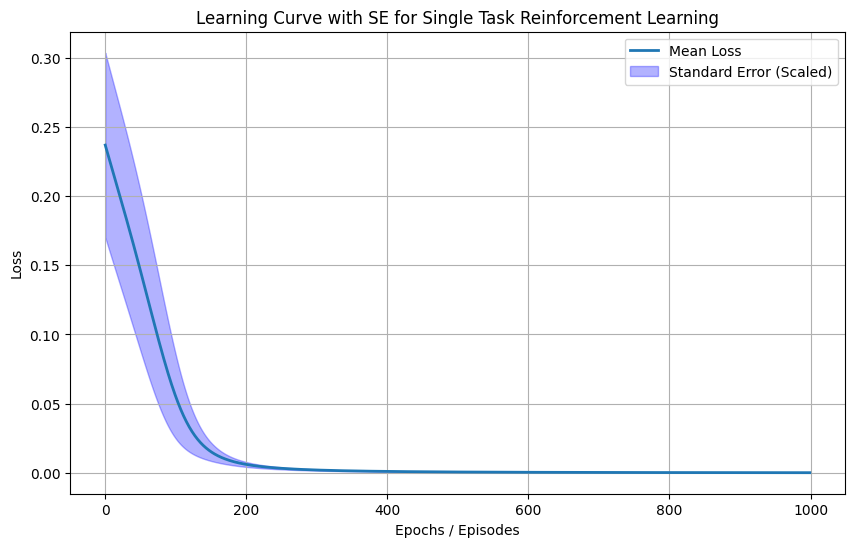

In [ ]:
plot_learning_curve_with_standard_error(mean_losses_reinforce, std_err_losses_reinforce, 'Learning Curve with SE for Single Task Reinforcement Learning')